<a href="https://colab.research.google.com/github/starlingomez/preworkmac/blob/master/NBA%20XGBOOST%20UPDATE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install nba_api xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.9/284.9 kB 4.5 MB/s eta 0:00:00


#Nikola Jokić

In [5]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd

# Nikola Jokić ID
player_id = '203999'

# Define the seasons and type of games you want to fetch
seasons = ['2022-23', '2023-24', '2024-25']  # Add more seasons if needed
season_type = 'Playoffs'  # Options: 'Regular Season', 'Playoffs', 'Pre Season', 'All-Star'

# Initialize an empty DataFrame to store all games
all_games = pd.DataFrame()

# Loop through each season and fetch game logs
for season in seasons:
    # Fetch the game log for the given season
    gamelog = playergamelog.PlayerGameLog(player_id=player_id, season=season, season_type_all_star=season_type)

    # Convert the response to a pandas DataFrame
    season_df = gamelog.get_data_frames()[0]

    # Append the data to the main DataFrame
    all_games = pd.concat([all_games, season_df], ignore_index=True)

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Display the complete DataFrame
print(all_games)

# Optionally save the data to a CSV file
all_games.to_csv('Nikola Jokić.csv', index=False)


   SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
0      42022     203999  0042200405  Jun 12, 2023  DEN vs. MIA  W   42   12   
1      42022     203999  0042200404  Jun 09, 2023    DEN @ MIA  W   37    8   
2      42022     203999  0042200403  Jun 07, 2023    DEN @ MIA  W   44   12   
3      42022     203999  0042200402  Jun 04, 2023  DEN vs. MIA  L   42   16   
4      42022     203999  0042200401  Jun 01, 2023  DEN vs. MIA  W   40    8   
5      42022     203999  0042200314  May 22, 2023    DEN @ LAL  W   45   11   
6      42022     203999  0042200313  May 20, 2023    DEN @ LAL  W   38    9   
7      42022     203999  0042200312  May 18, 2023  DEN vs. LAL  W   42    9   
8      42022     203999  0042200311  May 16, 2023  DEN vs. LAL  W   42   12   
9      42022     203999  0042200226  May 11, 2023    DEN @ PHX  W   38   13   
10     42022     203999  0042200225  May 09, 2023  DEN vs. PHX  W   38   12   
11     42022     203999  0042200224  May 07, 2023   

Data loaded successfully. Shape: (38, 27)

Missing values per column:
PTS           0
AST           0
STL           0
TOV           0
FGA           0
FGM           0
FG3M          0
FG3A          0
BLK           0
FTA           0
FTM           0
PLUS_MINUS    0
REB           0
dtype: int64

Preprocessed data shape: (38, 13)

Feature correlations with REB:
REB             1.000000
BLK             0.136305
FT_PCT          0.087612
FG3_PCT         0.072423
TOV             0.065132
PLUS_MINUS      0.038142
AST             0.035757
FG3M           -0.007190
FG3A           -0.047411
FTM            -0.053051
FG_PCT         -0.057377
FGA            -0.072551
USG            -0.079263
DEF_ACTIVITY   -0.137918
PTS            -0.145038
FGM            -0.151936
FTA            -0.165632
STL            -0.295399
Name: REB, dtype: float64


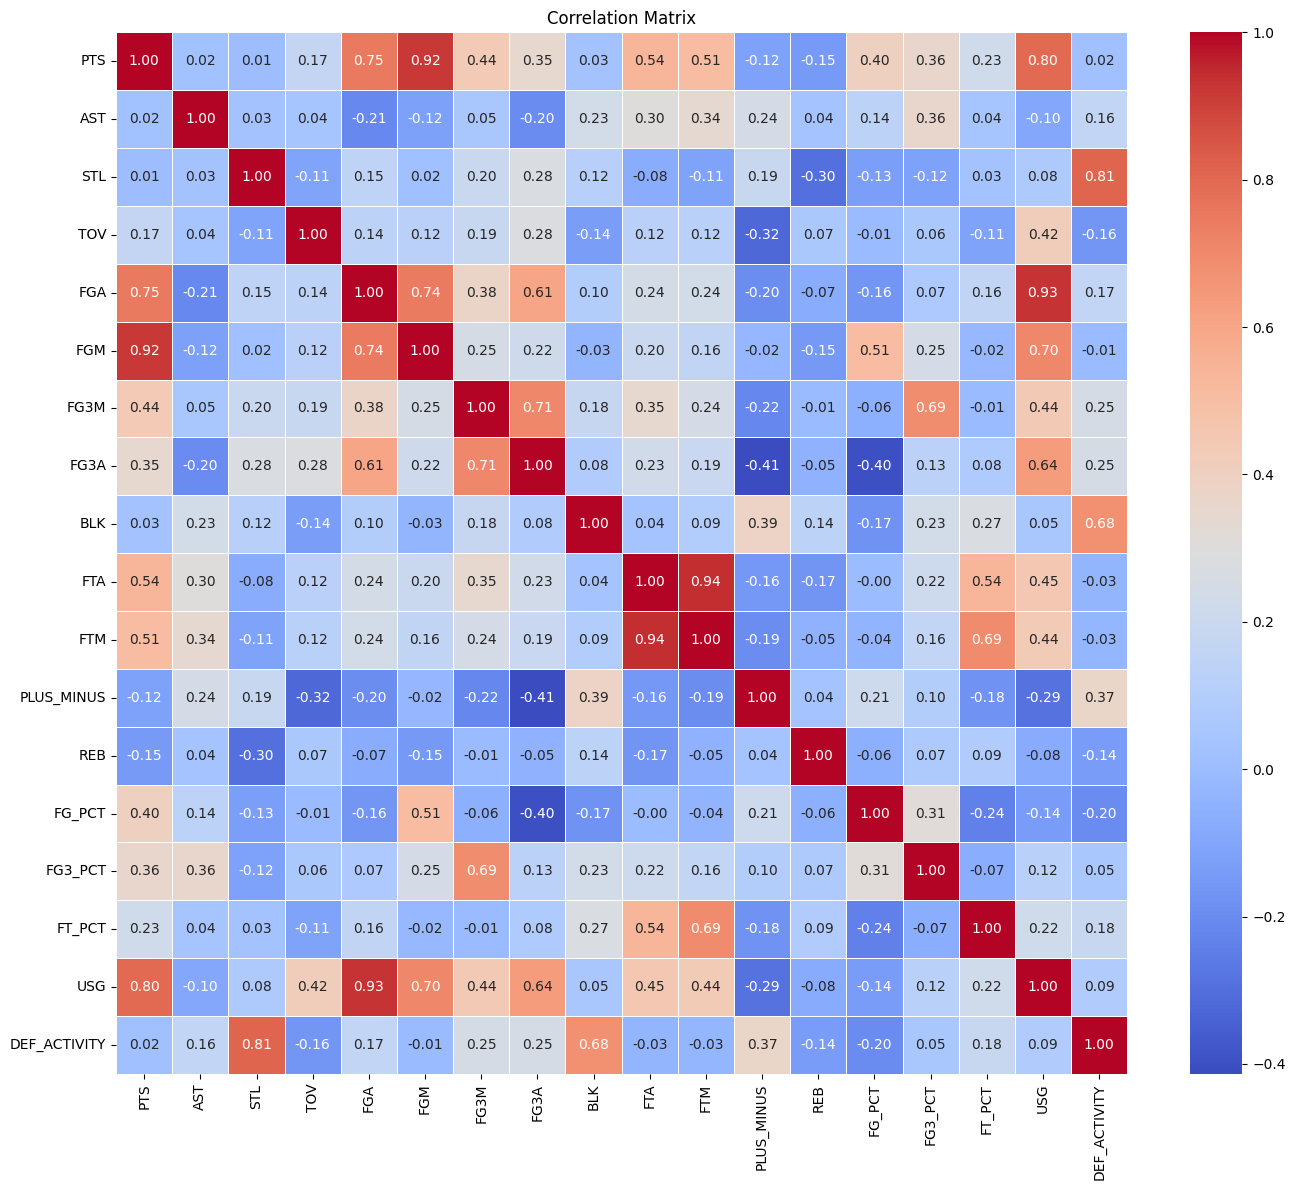


Training set: (30, 17), Test set: (8, 17)

Model Performance:
Training RMSE: 0.0219
Test RMSE: 7.0664
Training R²: 1.0000
Test R²: -0.9788
Test MAE: 6.4303


<Figure size 1200x600 with 0 Axes>

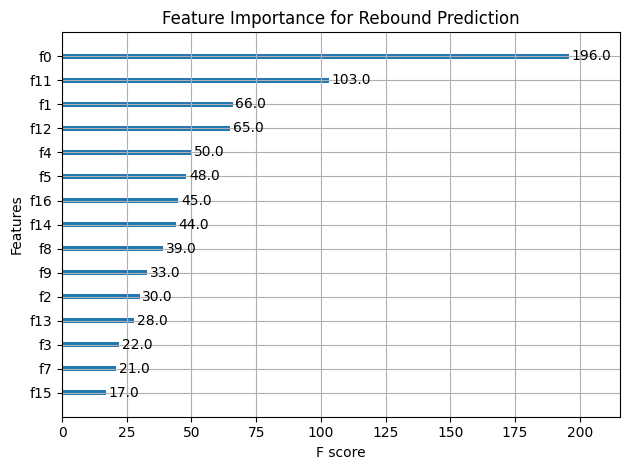


Sample Prediction for Next Game:
Predicted REB: 14.0
Actual REB: 10
Difference: 4.0

Model and scaler saved successfully.

Predictions for Upcoming Games:
   Actual_REB  Predicted_REB
0          10           14.0
1          11           11.6
2          10           16.0
3          16            6.7
4          20           14.0


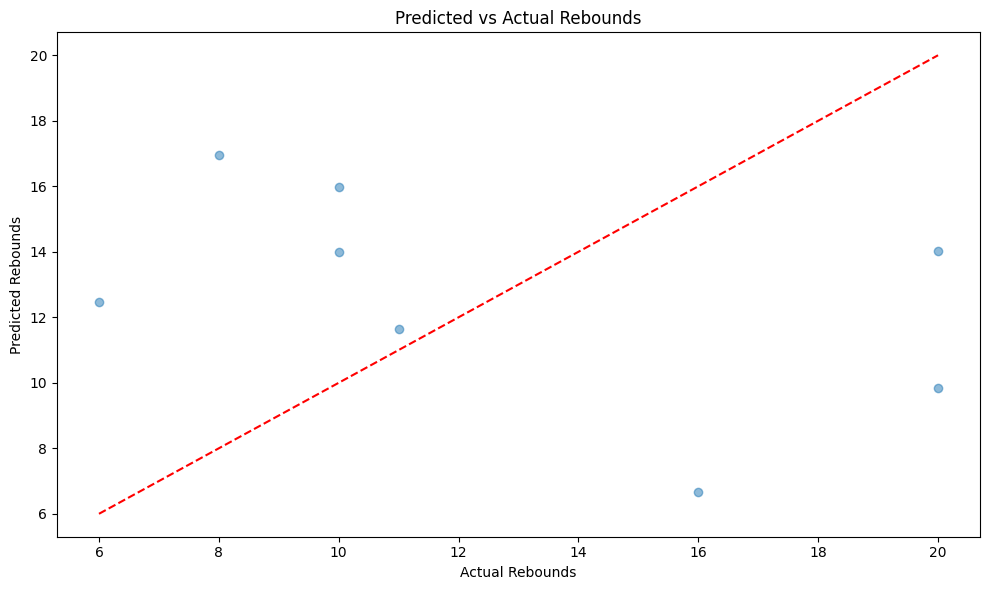


Model ready for deployment!


In [6]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Nikola Jokić.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Verify Required Columns ==========
features = [ 'PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']
target = 'REB'

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 3: Data Preprocessing ==========
# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
# For example, remove games where a player didn't play (minutes = 0)
if 'MIN' in df.columns:
    df = df[df['MIN'] > 0]

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Create any additional features that might help prediction
# Shooting efficiency
model_df['FG_PCT'] = model_df['FGM'] / model_df['FGA'].replace(0, 1)  # Avoid division by zero
model_df['FG3_PCT'] = model_df['FG3M'] / model_df['FG3A'].replace(0, 1)
model_df['FT_PCT'] = model_df['FTM'] / model_df['FTA'].replace(0, 1)

# Usage metrics
model_df['USG'] = model_df['FGA'] + 0.44 * model_df['FTA'] + model_df['TOV']

# Defensive activity
model_df['DEF_ACTIVITY'] = model_df['STL'] + model_df['BLK']

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with REB:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(14, 12))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (uncomment to use - can be time-consuming)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance for Rebound Prediction')
plt.tight_layout()
plt.show()

# ========== Step 11: Predictions for Next Game ==========
# Function to predict REB for a specific player
def predict_next_game_rebounds(player_data, model, scaler):
    """
    Predict next game rebounds for a player based on their stats

    Args:
        player_data: DataFrame row or dict containing player's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted rebounds for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(player_data, dict):
        player_df = pd.DataFrame([player_data])
    else:
        player_df = pd.DataFrame([player_data])

    # Apply same feature engineering as training data
    player_df['FG_PCT'] = player_df['FGM'] / player_df['FGA'].replace(0, 1)
    player_df['FG3_PCT'] = player_df['FG3M'] / player_df['FG3A'].replace(0, 1)
    player_df['FT_PCT'] = player_df['FTM'] / player_df['FTA'].replace(0, 1)
    player_df['USG'] = player_df['FGA'] + 0.44 * player_df['FTA'] + player_df['TOV']
    player_df['DEF_ACTIVITY'] = player_df['STL'] + player_df['BLK']

    # Ensure all features are present in the correct order
    feature_df = player_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(feature_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    # Round to 1 decimal place (reasonable for rebounds)
    return round(prediction, 1)

# Example: Predicting for a sample player
# (This would be replaced with actual player data)
sample_player = X_test.iloc[0].to_dict()  # Using first test set example
predicted_rebounds = predict_next_game_rebounds(sample_player, xgb_model, scaler)
actual_rebounds = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted REB: {predicted_rebounds}")
print(f"Actual REB: {actual_rebounds}")
print(f"Difference: {abs(predicted_rebounds - actual_rebounds):.1f}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('nba_player_rebounds_model.json')
import joblib
joblib.dump(scaler, 'rebounds_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 13: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple players
def predict_upcoming_games(players_df, model, scaler):
    """
    Make rebound predictions for multiple upcoming players/games

    Args:
        players_df: DataFrame with upcoming player stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = players_df.copy()

    # Apply same feature engineering
    result_df['FG_PCT'] = result_df['FGM'] / result_df['FGA'].replace(0, 1)
    result_df['FG3_PCT'] = result_df['FG3M'] / result_df['FG3A'].replace(0, 1)
    result_df['FT_PCT'] = result_df['FTM'] / result_df['FTA'].replace(0, 1)
    result_df['USG'] = result_df['FGA'] + 0.44 * result_df['FTA'] + result_df['TOV']
    result_df['DEF_ACTIVITY'] = result_df['STL'] + result_df['BLK']

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result (rounded to 1 decimal place)
    result_df['Predicted_REB'] = np.round(predictions, 1)

    return result_df

# Example: Predict for a sample of upcoming players/games
# (This would be replaced with actual upcoming player data)
sample_upcoming_players = X_test.head(5).copy()  # Using first 5 test examples

# Add player names if available
if 'PLAYER_NAME' in df.columns:
    sample_upcoming_players['PLAYER_NAME'] = df.loc[X_test.head(5).index, 'PLAYER_NAME'].values

predictions_df = predict_upcoming_games(sample_upcoming_players, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
if 'PLAYER_NAME' in predictions_df.columns:
    comparison_df = pd.DataFrame({
        'Player': predictions_df['PLAYER_NAME'],
        'Actual_REB': y_test.head(5).values,
        'Predicted_REB': predictions_df['Predicted_REB'].values
    })
else:
    comparison_df = pd.DataFrame({
        'Actual_REB': y_test.head(5).values,
        'Predicted_REB': predictions_df['Predicted_REB'].values
    })
print(comparison_df)

# ========== Step 14: Visualization of Predictions vs Actuals ==========
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rebounds')
plt.ylabel('Predicted Rebounds')
plt.title('Predicted vs Actual Rebounds')
plt.tight_layout()
plt.show()

print("\nModel ready for deployment!")

In [ ]:
from nba_api.stats.endpoints import playergamelog
import pandas as pd

# Devin Booker ID
player_id = '1626164'

# Define the seasons and type of games you want to fetch
seasons = ['2022-23', '2023-24', '2024-25']  # Add more seasons if needed
season_type = 'Regular Season'  # Options: 'Regular Season', 'Playoffs', 'Pre Season', 'All-Star'

# Initialize an empty DataFrame to store all games
all_games = pd.DataFrame()

# Loop through each season and fetch game logs
for season in seasons:
    # Fetch the game log for the given season
    gamelog = playergamelog.PlayerGameLog(player_id=player_id, season=season, season_type_all_star=season_type)

    # Convert the response to a pandas DataFrame
    season_df = gamelog.get_data_frames()[0]

    # Append the data to the main DataFrame
    all_games = pd.concat([all_games, season_df], ignore_index=True)

# Set pandas display options to show all rows
pd.set_option('display.max_rows', None)

# Display the complete DataFrame
print(all_games)

# Optionally save the data to a CSV file
all_games.to_csv('Devin Booker.csv', index=False)


    SEASON_ID  Player_ID     Game_ID     GAME_DATE      MATCHUP WL  MIN  FGM  \
0       22022    1626164  0022201201  APR 06, 2023  PHX vs. DEN  W   37    3   
1       22022    1626164  0022201188  APR 04, 2023  PHX vs. SAS  W   33    9   
2       22022    1626164  0022201172  APR 02, 2023    PHX @ OKC  W   37    8   
3       22022    1626164  0022201160  MAR 31, 2023  PHX vs. DEN  W   35    9   
4       22022    1626164  0022201144  MAR 29, 2023  PHX vs. MIN  W   36    8   
5       22022    1626164  0022201125  MAR 27, 2023    PHX @ UTA  W   34    7   
6       22022    1626164  0022201110  MAR 25, 2023  PHX vs. PHI  W   32    9   
7       22022    1626164  0022201105  MAR 24, 2023    PHX @ SAC  L   33   10   
8       22022    1626164  0022201092  MAR 22, 2023    PHX @ LAL  L   41   11   
9       22022    1626164  0022201064  MAR 19, 2023    PHX @ OKC  L   36   18   
10      22022    1626164  0022201046  MAR 16, 2023  PHX vs. ORL  W   36    7   
11      22022    1626164  0022201033  MA

Data loaded successfully. Shape: (25, 27)

Missing values per column:
PTS           0
AST           0
STL           0
TOV           0
FGA           0
FGM           0
FG3M          0
FG3A          0
BLK           0
FTA           0
FTM           0
PLUS_MINUS    0
REB           0
dtype: int64

Preprocessed data shape: (25, 13)

Feature correlations with REB:
REB             1.000000
FGM             0.630347
PTS             0.617223
USG             0.531943
FGA             0.529033
PLUS_MINUS      0.394529
FG_PCT          0.387186
FTA             0.279983
FTM             0.259195
BLK             0.189740
FT_PCT          0.031395
TOV             0.020664
DEF_ACTIVITY   -0.010836
AST            -0.034169
STL            -0.213000
FG3M                 NaN
FG3A                 NaN
FG3_PCT              NaN
Name: REB, dtype: float64


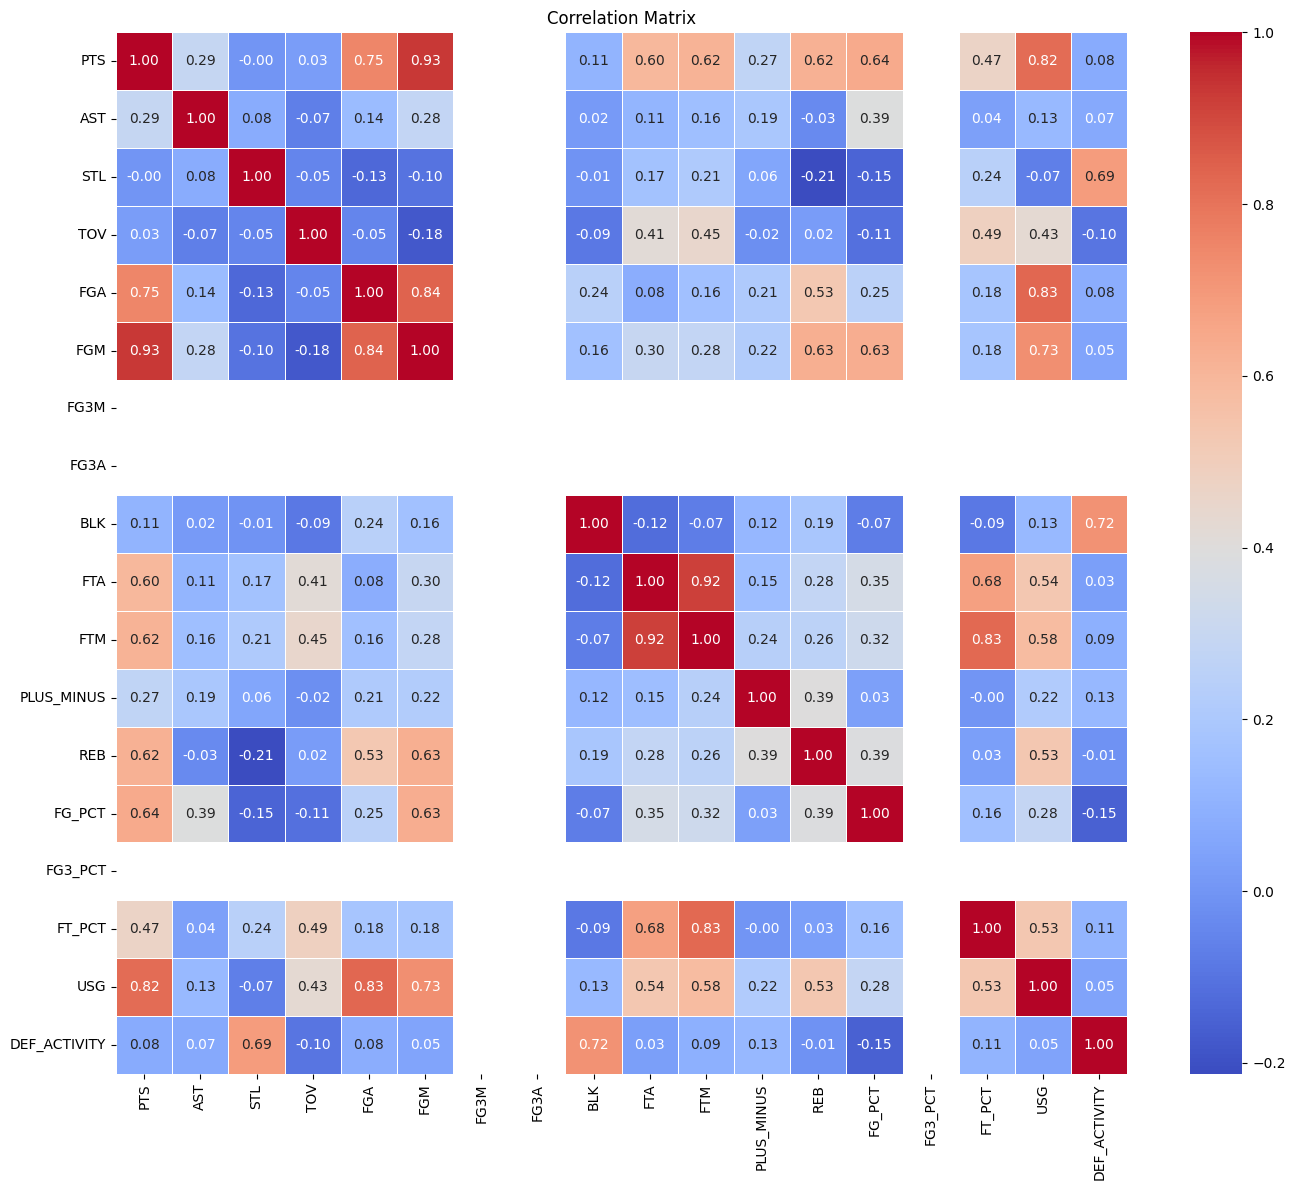


Training set: (20, 17), Test set: (5, 17)

Model Performance:
Training RMSE: 0.0258
Test RMSE: 3.3970
Training R²: 1.0000
Test R²: 0.2964
Test MAE: 3.1947


<Figure size 1200x600 with 0 Axes>

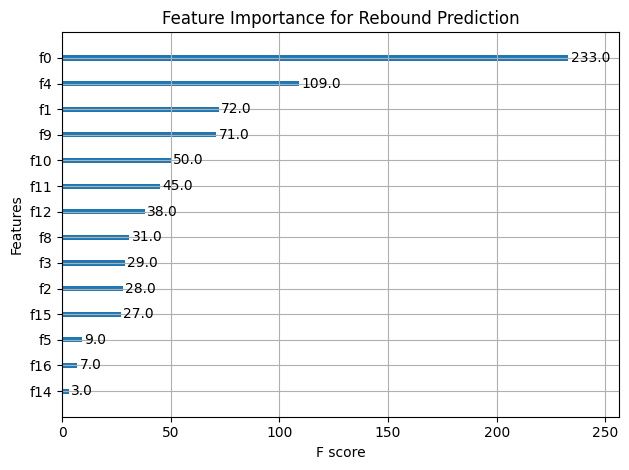


Sample Prediction for Next Game:
Predicted REB: 8.300000190734863
Actual REB: 10
Difference: 1.7

Model and scaler saved successfully.

Predictions for Upcoming Games:
   Actual_REB  Predicted_REB
0          10            8.3
1           5            7.6
2          15           10.2
3           6           10.3
4          14           11.5


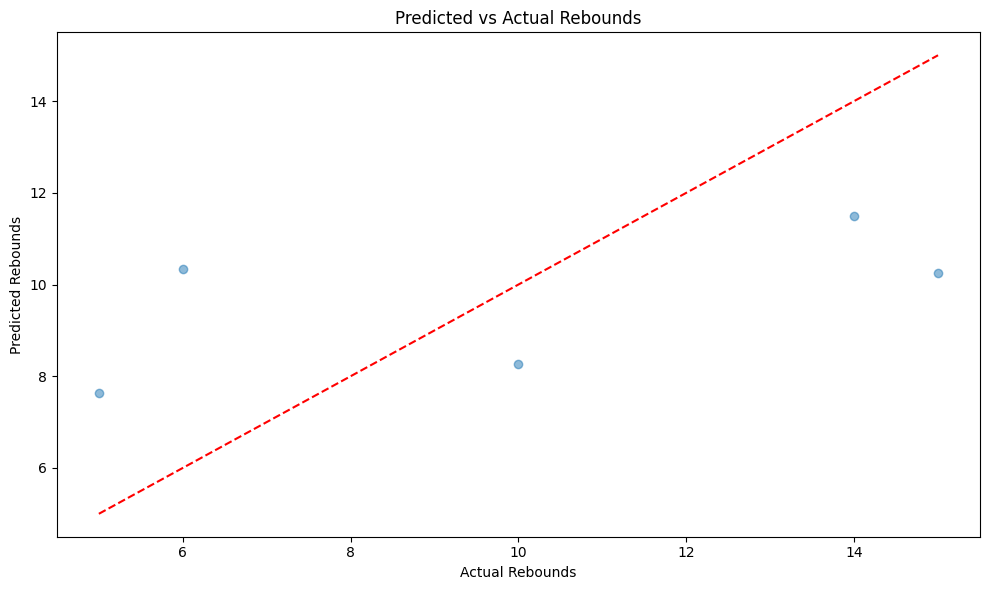


Model ready for deployment!


In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Rudy Gobert.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Verify Required Columns ==========
features = [ 'PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS']
target = 'REB'

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 3: Data Preprocessing ==========
# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
# For example, remove games where a player didn't play (minutes = 0)
if 'MIN' in df.columns:
    df = df[df['MIN'] > 0]

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Create any additional features that might help prediction
# Shooting efficiency
model_df['FG_PCT'] = model_df['FGM'] / model_df['FGA'].replace(0, 1)  # Avoid division by zero
model_df['FG3_PCT'] = model_df['FG3M'] / model_df['FG3A'].replace(0, 1)
model_df['FT_PCT'] = model_df['FTM'] / model_df['FTA'].replace(0, 1)

# Usage metrics
model_df['USG'] = model_df['FGA'] + 0.44 * model_df['FTA'] + model_df['TOV']

# Defensive activity
model_df['DEF_ACTIVITY'] = model_df['STL'] + model_df['BLK']

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with REB:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(14, 12))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (uncomment to use - can be time-consuming)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance for Rebound Prediction')
plt.tight_layout()
plt.show()

# ========== Step 11: Predictions for Next Game ==========
# Function to predict REB for a specific player
def predict_next_game_rebounds(player_data, model, scaler):
    """
    Predict next game rebounds for a player based on their stats

    Args:
        player_data: DataFrame row or dict containing player's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted rebounds for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(player_data, dict):
        player_df = pd.DataFrame([player_data])
    else:
        player_df = pd.DataFrame([player_data])

    # Apply same feature engineering as training data
    player_df['FG_PCT'] = player_df['FGM'] / player_df['FGA'].replace(0, 1)
    player_df['FG3_PCT'] = player_df['FG3M'] / player_df['FG3A'].replace(0, 1)
    player_df['FT_PCT'] = player_df['FTM'] / player_df['FTA'].replace(0, 1)
    player_df['USG'] = player_df['FGA'] + 0.44 * player_df['FTA'] + player_df['TOV']
    player_df['DEF_ACTIVITY'] = player_df['STL'] + player_df['BLK']

    # Ensure all features are present in the correct order
    feature_df = player_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(feature_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    # Round to 1 decimal place (reasonable for rebounds)
    return round(prediction, 1)

# Example: Predicting for a sample player
# (This would be replaced with actual player data)
sample_player = X_test.iloc[0].to_dict()  # Using first test set example
predicted_rebounds = predict_next_game_rebounds(sample_player, xgb_model, scaler)
actual_rebounds = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted REB: {predicted_rebounds}")
print(f"Actual REB: {actual_rebounds}")
print(f"Difference: {abs(predicted_rebounds - actual_rebounds):.1f}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('nba_player_rebounds_model.json')
import joblib
joblib.dump(scaler, 'rebounds_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 13: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple players
def predict_upcoming_games(players_df, model, scaler):
    """
    Make rebound predictions for multiple upcoming players/games

    Args:
        players_df: DataFrame with upcoming player stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = players_df.copy()

    # Apply same feature engineering
    result_df['FG_PCT'] = result_df['FGM'] / result_df['FGA'].replace(0, 1)
    result_df['FG3_PCT'] = result_df['FG3M'] / result_df['FG3A'].replace(0, 1)
    result_df['FT_PCT'] = result_df['FTM'] / result_df['FTA'].replace(0, 1)
    result_df['USG'] = result_df['FGA'] + 0.44 * result_df['FTA'] + result_df['TOV']
    result_df['DEF_ACTIVITY'] = result_df['STL'] + result_df['BLK']

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result (rounded to 1 decimal place)
    result_df['Predicted_REB'] = np.round(predictions, 1)

    return result_df

# Example: Predict for a sample of upcoming players/games
# (This would be replaced with actual upcoming player data)
sample_upcoming_players = X_test.head(5).copy()  # Using first 5 test examples

# Add player names if available
if 'PLAYER_NAME' in df.columns:
    sample_upcoming_players['PLAYER_NAME'] = df.loc[X_test.head(5).index, 'PLAYER_NAME'].values

predictions_df = predict_upcoming_games(sample_upcoming_players, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
if 'PLAYER_NAME' in predictions_df.columns:
    comparison_df = pd.DataFrame({
        'Player': predictions_df['PLAYER_NAME'],
        'Actual_REB': y_test.head(5).values,
        'Predicted_REB': predictions_df['Predicted_REB'].values
    })
else:
    comparison_df = pd.DataFrame({
        'Actual_REB': y_test.head(5).values,
        'Predicted_REB': predictions_df['Predicted_REB'].values
    })
print(comparison_df)

# ========== Step 14: Visualization of Predictions vs Actuals ==========
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rebounds')
plt.ylabel('Predicted Rebounds')
plt.title('Predicted vs Actual Rebounds')
plt.tight_layout()
plt.show()

print("\nModel ready for deployment!")

Retrieving player data from NBA API...
Found Rudy Gobert with ID: 203497
Retrieving data for season: 2023-24
Retrieving data for season: 2024-25
Successfully retrieved 148 games.
Saved data to Rudy_Gobert.csv

Missing values per column:
PTS           0
AST           0
STL           0
TOV           0
FGA           0
FGM           0
FG3M          0
FG3A          0
BLK           0
FTA           0
FTM           0
PLUS_MINUS    0
HOME          0
PTS+AST       0
BLKS+STLS     0
REB           0
dtype: int64

Preprocessed data shape: (148, 23)

Feature correlations with REB:
REB             1.000000
USG             0.449178
FGA             0.444332
PTS             0.385329
FGM             0.384865
PTS+AST         0.382042
PLUS_MINUS      0.302038
BLK             0.196612
BLKS+STLS       0.184537
DEF_ACTIVITY    0.184537
HOME            0.147081
FTA             0.141349
FTM             0.140799
FT_PCT          0.097469
TOV             0.075127
FG_PCT          0.056530
AST             0.018566
S

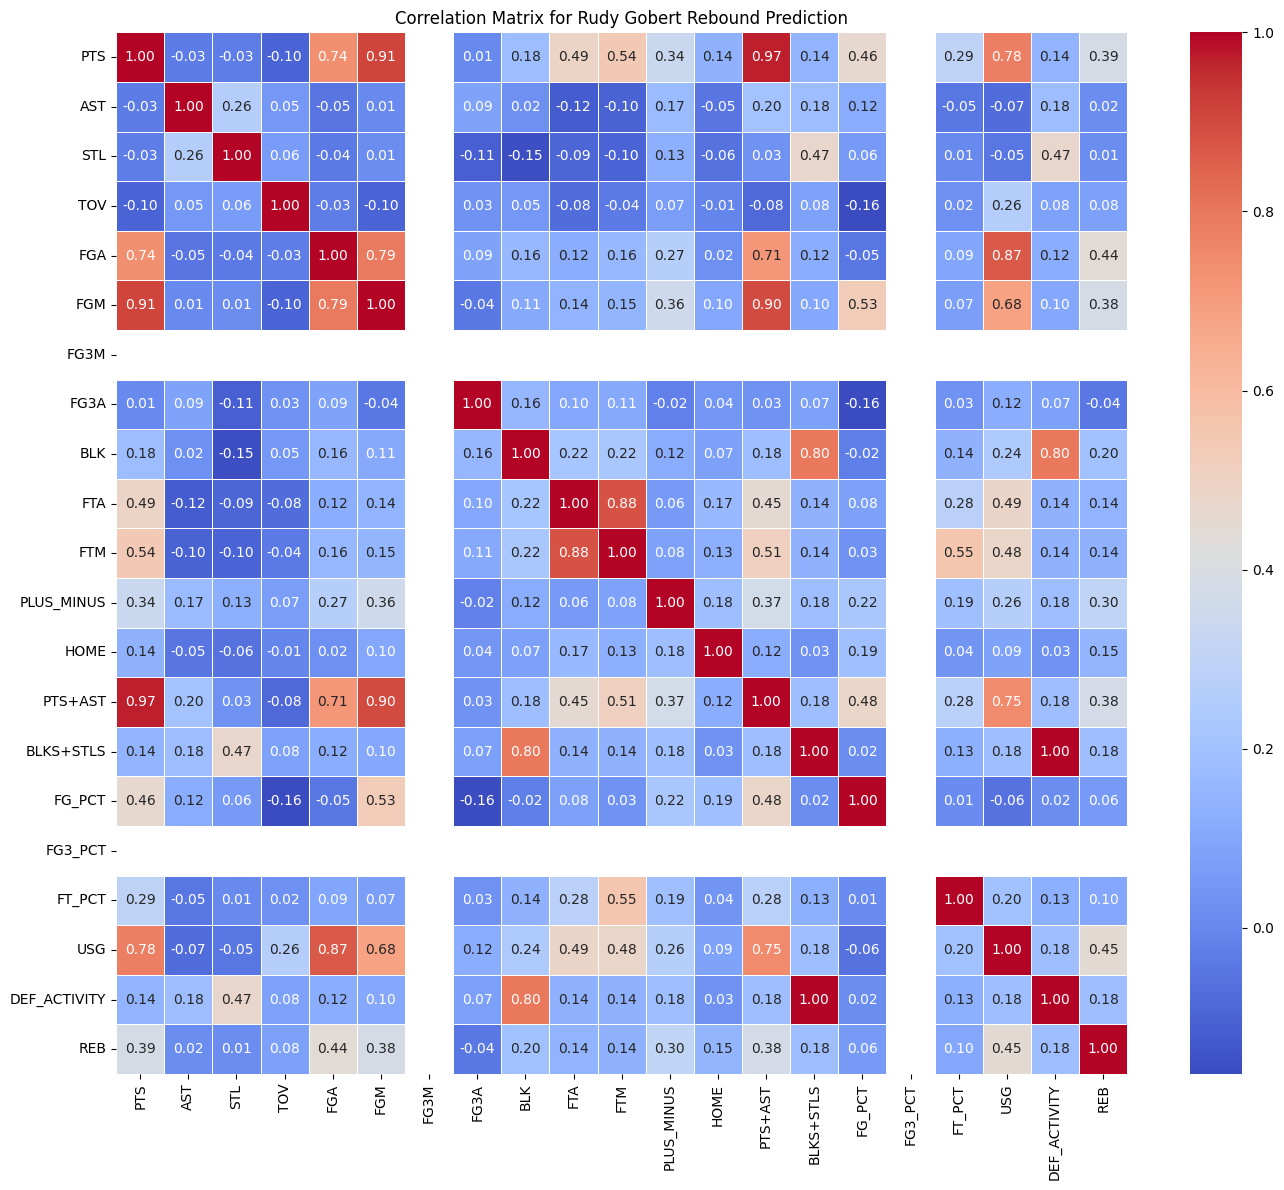


Training set: (118, 20), Test set: (30, 20)

Model Performance for Rudy Gobert Rebound Prediction:
Training RMSE: 0.6005
Test RMSE: 5.0349
Training R²: 0.9780
Test R²: -0.3649
Test MAE: 4.3366


<Figure size 1200x600 with 0 Axes>

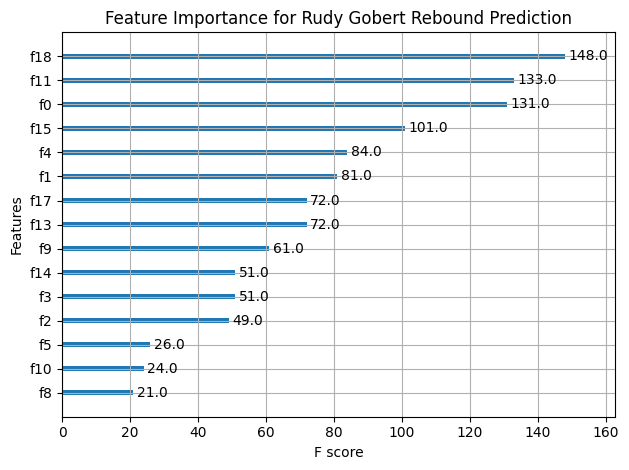


Sample Next Game Stats:
PTS: 13
AST: 2
STL: 0
TOV: 1
FGA: 8
FGM: 5
FG3M: 0
FG3A: 0
BLK: 1
FTA: 4
FTM: 3
PLUS_MINUS: -10
HOME: 0
PTS+AST: 15
BLKS+STLS: 1
FG_PCT: 0.625
FG3_PCT: 0.0
FT_PCT: 0.75
USG: 10.76
DEF_ACTIVITY: 1

Predicted REB for next game: 13.199999809265137

Model and scaler saved successfully as Rudy_Gobert_rebounds_model.json and Rudy_Gobert_rebounds_scaler.pkl.


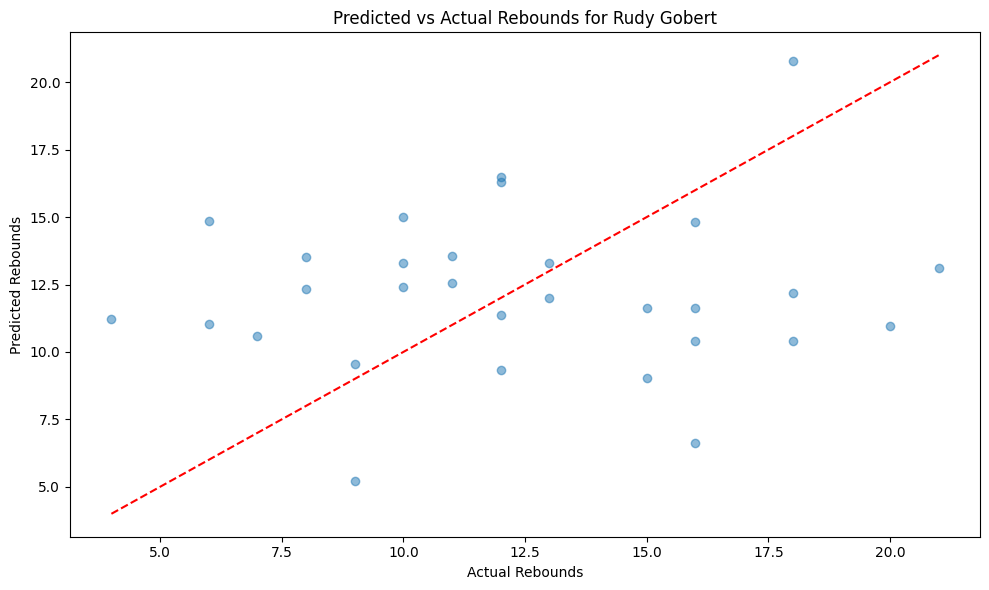

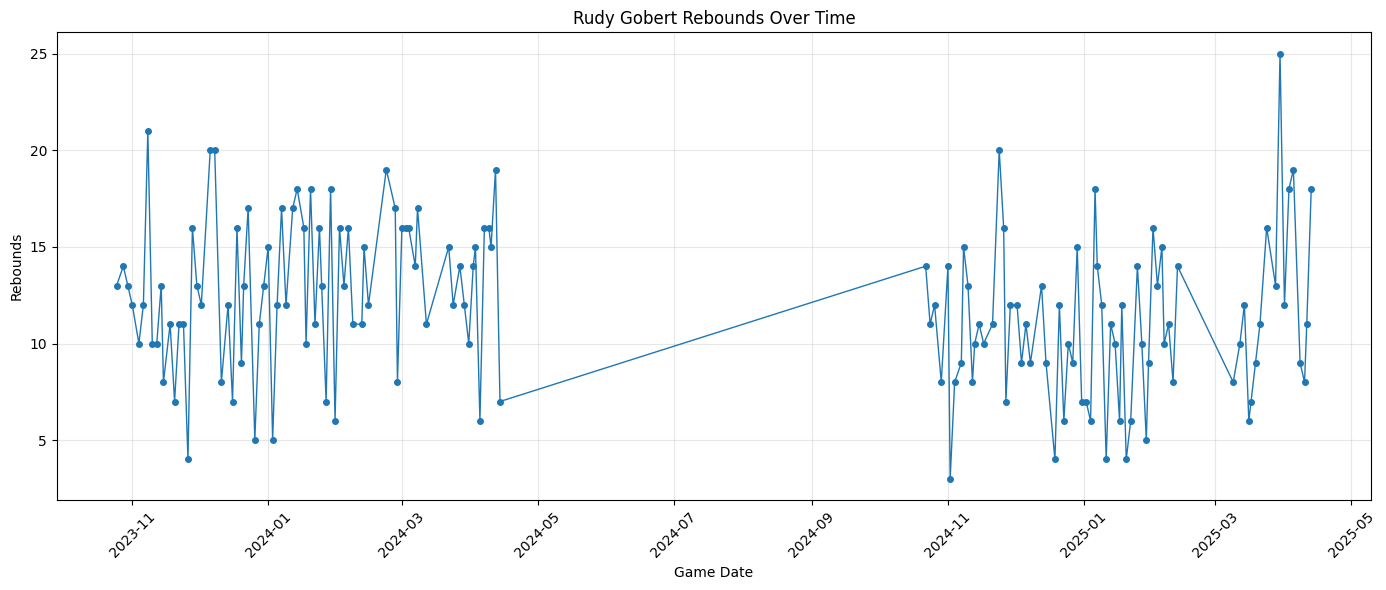


Rebound Prediction Model for Rudy Gobert ready for deployment!


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Add NBA API imports
from nba_api.stats.endpoints import PlayerGameLog
from nba_api.stats.static import players

# ========== Step 1: Data Retrieval with NBA API ==========
print("Retrieving player data from NBA API...")

# Find player's ID
player_name = "Rudy Gobert"  # Can be changed to any player
player_info = players.find_players_by_full_name(player_name)

if not player_info:
    raise ValueError(f"Player '{player_name}' not found in the NBA API database.")

player_id = player_info[0]['id']
print(f"Found {player_name} with ID: {player_id}")

# Retrieve game logs for specified seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    try:
        season_log = PlayerGameLog(player_id=player_id, season=season).get_data_frames()[0]
        gamelogs.append(season_log)
    except Exception as e:
        print(f"Error retrieving data for season {season}: {e}")

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True) if gamelogs else None

if df is None or df.empty:
    raise ValueError("Failed to retrieve any game data for the specified player and seasons.")

print(f"Successfully retrieved {len(df)} games.")

# Select the columns of interest
required_columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]

# Check if all required columns are present
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the API data: {missing_columns}")

# Select columns from dataframe
df = df[required_columns]

# ========== Step 2: Feature Engineering ==========
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST'] = df['PTS'] + df['AST']
df['REB+AST'] = df['REB'] + df['AST']
df['PTS+REB'] = df['PTS'] + df['REB']
df['BLKS+STLS'] = df['BLK'] + df['STL']

# Convert GAME_DATE to datetime
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
df['HOME'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Create an 'OPPONENT' feature
df['OPPONENT'] = df['MATCHUP'].apply(lambda x: x.split()[-1])

# Save to CSV
output_filename = f'{player_name.replace(" ", "_")}.csv'
df.to_csv(output_filename, index=False)
print(f"Saved data to {output_filename}")

# Create a copy for modeling (we'll use REB as target variable)
model_df = df.copy()

# ========== Step 3: Data Preprocessing ==========
# Define features and target for the rebound prediction model
features = ['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS', 'HOME']
target = 'REB'

# Add the combined statistics to features
combined_features = ['PTS+AST', 'BLKS+STLS']
features.extend(combined_features)

# Handle missing values
print("\nMissing values per column:")
print(model_df[features + [target]].isnull().sum())

# Fill missing values using appropriate strategy
for col in features + [target]:
    if model_df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        model_df[col] = model_df[col].fillna(model_df[col].median())

# Clean the data: remove rows with extreme or invalid values
# For example, remove games where a player didn't play (minutes = 0)
if 'MIN' in model_df.columns:
    model_df = model_df[model_df['MIN'] > 0]

print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Additional Feature Engineering ==========
# Create any additional features that might help prediction
# Shooting efficiency
model_df['FG_PCT'] = model_df['FGM'] / model_df['FGA'].replace(0, 1)  # Avoid division by zero
model_df['FG3_PCT'] = model_df['FG3M'] / model_df['FG3A'].replace(0, 1)
model_df['FT_PCT'] = model_df['FTM'] / model_df['FTA'].replace(0, 1)

# Usage metrics
model_df['USG'] = model_df['FGA'] + 0.44 * model_df['FTA'] + model_df['TOV']

# Defensive activity
model_df['DEF_ACTIVITY'] = model_df['STL'] + model_df['BLK']

# Add these new features to our features list
engineered_features = ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'USG', 'DEF_ACTIVITY']
features.extend(engineered_features)

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df[features + [target]].corr()[target].sort_values(ascending=False)
print("\nFeature correlations with REB:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(14, 12))
correlation_matrix = model_df[features + [target]].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Matrix for {player_name} Rebound Prediction')
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df[features]
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (uncomment to use - can be time-consuming)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nModel Performance for {player_name} Rebound Prediction:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title(f'Feature Importance for {player_name} Rebound Prediction')
plt.tight_layout()
plt.show()

# ========== Step 11: Prediction for Next Game ==========
# Function to predict REB for a specific player
def predict_next_game_rebounds(player_stats, model, scaler, feature_list):
    """
    Predict next game rebounds for a player based on their stats

    Args:
        player_stats: Dict containing player's stats for the next game
        model: Trained XGBoost model
        scaler: Fitted StandardScaler
        feature_list: List of features used by the model

    Returns:
        Predicted rebounds for the next game
    """
    # Convert input to DataFrame
    player_df = pd.DataFrame([player_stats])

    # Ensure all required features are present
    # Calculate composite features if not provided
    if 'PTS+AST' not in player_df.columns and 'PTS' in player_df.columns and 'AST' in player_df.columns:
        player_df['PTS+AST'] = player_df['PTS'] + player_df['AST']

    if 'BLKS+STLS' not in player_df.columns and 'BLK' in player_df.columns and 'STL' in player_df.columns:
        player_df['BLKS+STLS'] = player_df['BLK'] + player_df['STL']

    # Calculate efficiency stats
    if 'FG_PCT' not in player_df.columns:
        player_df['FG_PCT'] = player_df['FGM'] / player_df['FGA'].replace(0, 1)

    if 'FG3_PCT' not in player_df.columns:
        player_df['FG3_PCT'] = player_df['FG3M'] / player_df['FG3A'].replace(0, 1)

    if 'FT_PCT' not in player_df.columns:
        player_df['FT_PCT'] = player_df['FTM'] / player_df['FTA'].replace(0, 1)

    if 'USG' not in player_df.columns:
        player_df['USG'] = player_df['FGA'] + 0.44 * player_df['FTA'] + player_df['TOV']

    if 'DEF_ACTIVITY' not in player_df.columns:
        player_df['DEF_ACTIVITY'] = player_df['STL'] + player_df['BLK']

    # Ensure all features are present in the correct order
    for feat in feature_list:
        if feat not in player_df.columns:
            raise ValueError(f"Missing feature: {feat}")

    # Select only the required features
    feature_df = player_df[feature_list]

    # Scale features
    scaled_features = scaler.transform(feature_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    # Round to 1 decimal place (reasonable for rebounds)
    return round(prediction, 1)

# Example: Using the most recent game as an example for next game prediction
sample_recent_game = model_df.iloc[-1][features].to_dict()
print("\nSample Next Game Stats:")
for key, value in sample_recent_game.items():
    print(f"{key}: {value}")

# Predict rebounds for the next game
predicted_rebounds = predict_next_game_rebounds(sample_recent_game, xgb_model, scaler, features)
print(f"\nPredicted REB for next game: {predicted_rebounds}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
model_filename = f'{player_name.replace(" ", "_")}_rebounds_model.json'
scaler_filename = f'{player_name.replace(" ", "_")}_rebounds_scaler.pkl'

xgb_model.save_model(model_filename)
import joblib
joblib.dump(scaler, scaler_filename)
joblib.dump(features, f'{player_name.replace(" ", "_")}_model_features.pkl')

print(f"\nModel and scaler saved successfully as {model_filename} and {scaler_filename}.")

# ========== Step 13: Visualization of Predictions vs Actuals ==========
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rebounds')
plt.ylabel('Predicted Rebounds')
plt.title(f'Predicted vs Actual Rebounds for {player_name}')
plt.tight_layout()
plt.show()

# ========== Step 14: Time Series Analysis ==========
# Analyze rebound trends over time
plt.figure(figsize=(14, 6))
model_df.sort_values('GAME_DATE', inplace=True)
plt.plot(model_df['GAME_DATE'], model_df['REB'], marker='o', linestyle='-', linewidth=1, markersize=4)
plt.title(f'{player_name} Rebounds Over Time')
plt.xlabel('Game Date')
plt.ylabel('Rebounds')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nRebound Prediction Model for {player_name} ready for deployment!")

Retrieving player data from NBA API...
Found player ID for LeBron James: 2544
Retrieving data for season: 2023-24
Retrieving data for season: 2024-25
Data retrieved successfully. Shape: (141, 16)
Data saved to LeBron_James.csv

Missing values per column:
PTS            0
AST            0
STL            0
TOV            0
FGA            0
FGM            0
FG3M           0
FG3A           0
BLK            0
FTA            0
FTM            0
PLUS_MINUS     0
PTS+REB+AST    0
PTS+AST        0
REB+AST        0
PTS+REB        0
BLKS+STLS      0
HOME           0
REB            0
dtype: int64

Preprocessed data shape: (141, 19)

Feature correlations with REB:
REB             1.000000
REB+AST         0.789688
PTS+REB         0.523267
PTS+REB+AST     0.509917
USG             0.191571
TOV             0.172930
PTS+AST         0.135781
FTA             0.126552
FG3A            0.123040
PTS             0.115854
FGA             0.107222
FGM             0.086053
FTM             0.084277
FG3M            

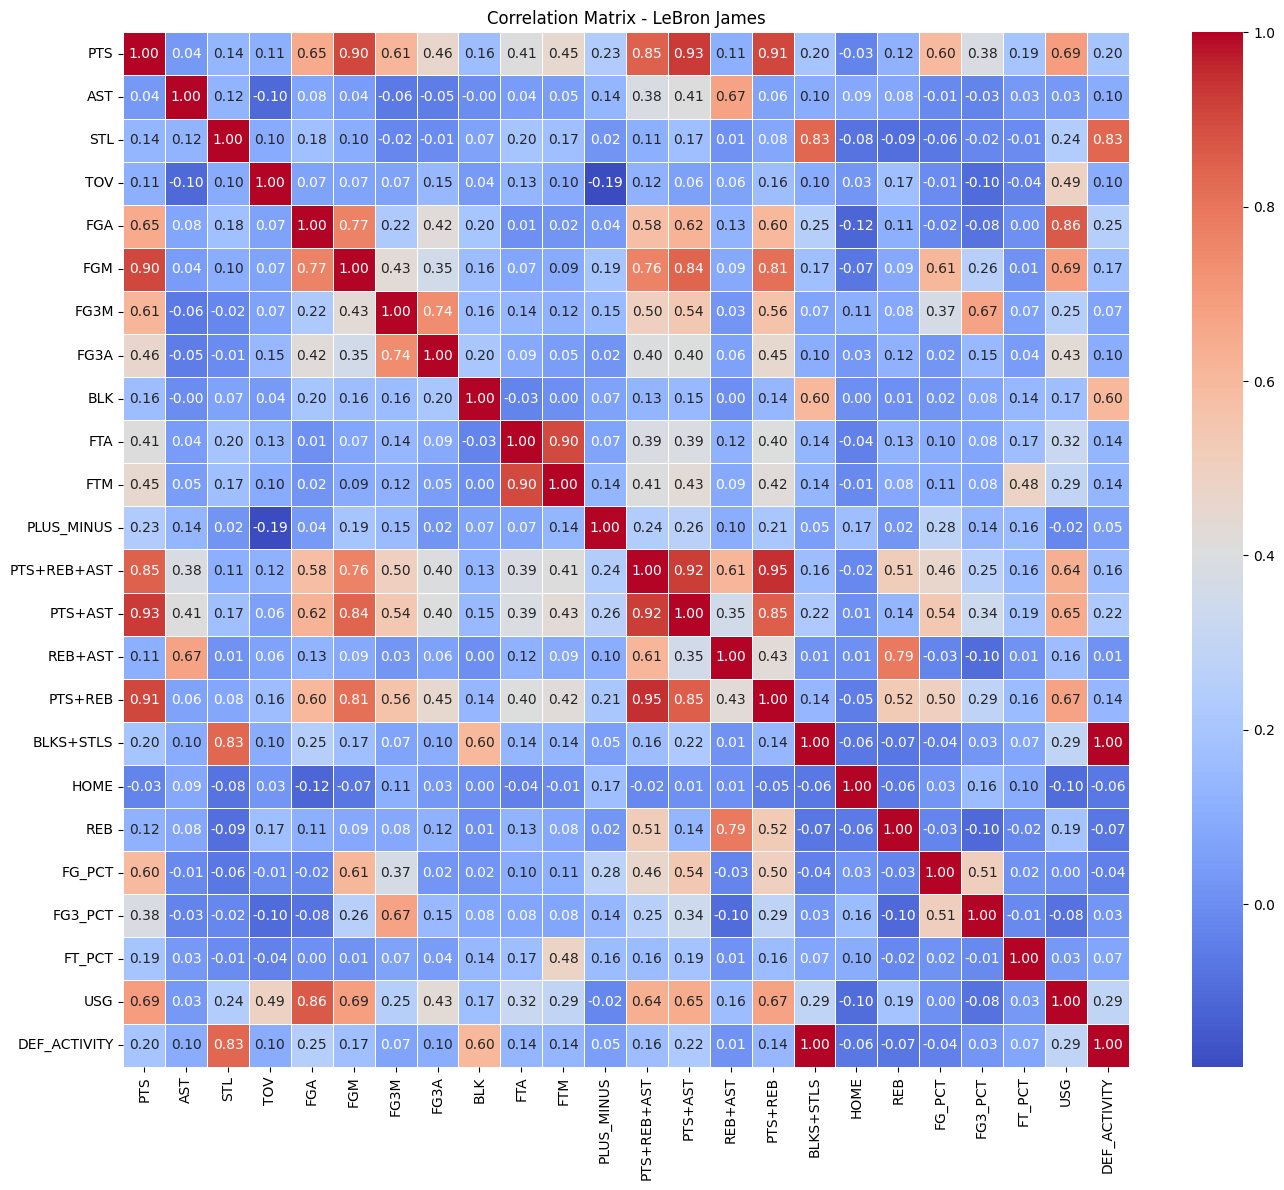


Training set: (112, 23), Test set: (29, 23)

Model Performance:
Training RMSE: 0.0727
Test RMSE: 1.1421
Training R²: 0.9996
Test R²: 0.8897
Test MAE: 0.8677


<Figure size 1200x600 with 0 Axes>

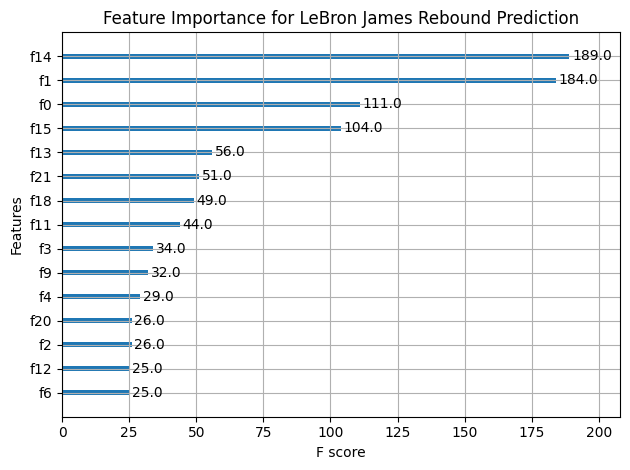


Sample Prediction for Next Game:
Predicted REB: 13.600000381469727
Actual REB: 15
Difference: 1.4

Model saved as LeBron_James_rebounds_model.json
Scaler saved as LeBron_James_rebounds_scaler.pkl

Predictions for Upcoming Games:
   Game  Actual_REB  Predicted_REB
0     1          15      13.600000
1     2          10       9.600000
2     3           5       6.300000
3     4           4       4.000000
4     5          17      16.700001


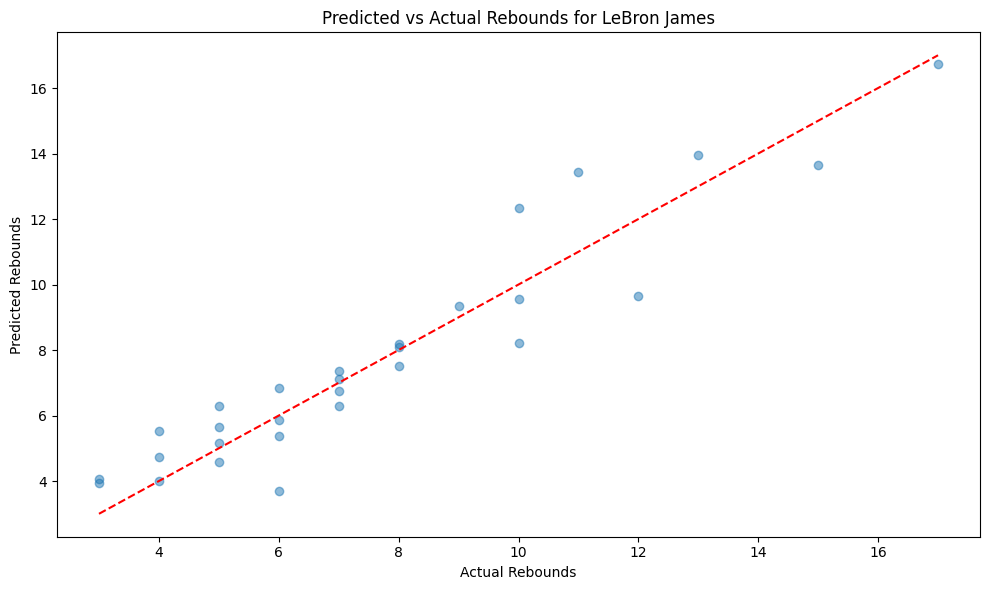


===== LeBron James Rebound Prediction Model Summary =====
Total games analyzed: 141
Seasons included: 2023-24, 2024-25
Average rebounds per game: 7.5
Model accuracy (R²): 0.8897
Average prediction error (MAE): 0.87 rebounds

Model ready for deployment!


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
from nba_api.stats.static import players
from nba_api.stats.endpoints import PlayerGameLog
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Data Retrieval using NBA API ==========
print("Retrieving player data from NBA API...")

# Find player ID
player_name = "LeBron James"
player_id = players.find_players_by_full_name(player_name)[0]['id']
print(f"Found player ID for {player_name}: {player_id}")

# Retrieve game logs for the specified seasons
seasons = ['2023-24', '2024-25']
gamelogs = []

for season in seasons:
    print(f"Retrieving data for season: {season}")
    season_log = PlayerGameLog(player_id=player_id, season=season).get_data_frames()[0]
    gamelogs.append(season_log)

# Combine the game logs from both seasons
df = pd.concat(gamelogs, ignore_index=True)

# Select the columns of interest
columns = [
    'Game_ID', 'GAME_DATE', 'MATCHUP', 'PTS', 'AST',
    'STL', 'REB', 'TOV', 'FGA', 'FGM', 'FG3M',
    'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS'
]
df = df[columns]

print(f"Data retrieved successfully. Shape: {df.shape}")

# ========== Step 2: Feature Engineering ==========
# Create additional stats columns
df['PTS+REB+AST'] = df['PTS'] + df['REB'] + df['AST']
df['PTS+AST'] = df['PTS'] + df['AST']
df['REB+AST'] = df['REB'] + df['AST']
df['PTS+REB'] = df['PTS'] + df['REB']
df['BLKS+STLS'] = df['BLK'] + df['STL']

# Convert GAME_DATE to datetime
df['GAME_DATE'] = pd.to_datetime(df['GAME_DATE'])

# Create a 'HOME' feature (1 if 'vs.' in MATCHUP, else 0)
df['HOME'] = df['MATCHUP'].apply(lambda x: 1 if 'vs.' in x else 0)

# Create an 'OPPONENT' feature
df['OPPONENT'] = df['MATCHUP'].apply(lambda x: x.split()[-1])

# Save to CSV
output_filename = f'{player_name.replace(" ", "_")}.csv'
df.to_csv(output_filename, index=False)
print(f"Data saved to {output_filename}")

# ========== Step 3: Verify Required Columns ==========
features = ['PTS', 'AST', 'STL', 'TOV', 'FGA', 'FGM', 'FG3M', 'FG3A', 'BLK', 'FTA', 'FTM', 'PLUS_MINUS',
            'PTS+REB+AST', 'PTS+AST', 'REB+AST', 'PTS+REB', 'BLKS+STLS', 'HOME']
target = 'REB'

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 4: Data Preprocessing ==========
# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # Fill with median
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
# For example, remove games where a player didn't play (minutes = 0)
if 'MIN' in df.columns:
    df = df[df['MIN'] > 0]

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 5: Additional Feature Engineering ==========
# Create any additional features that might help prediction
# Shooting efficiency
model_df['FG_PCT'] = model_df['FGM'] / model_df['FGA'].replace(0, 1)  # Avoid division by zero
model_df['FG3_PCT'] = model_df['FG3M'] / model_df['FG3A'].replace(0, 1)
model_df['FT_PCT'] = model_df['FTM'] / model_df['FTA'].replace(0, 1)

# Usage metrics
model_df['USG'] = model_df['FGA'] + 0.44 * model_df['FTA'] + model_df['TOV']

# Defensive activity
model_df['DEF_ACTIVITY'] = model_df['STL'] + model_df['BLK']

# ========== Step 6: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with REB:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(14, 12))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Correlation Matrix - {player_name}')
plt.tight_layout()
plt.show()

# ========== Step 7: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 8: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 9: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (uncomment to use - can be time-consuming)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 10: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 11: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title(f'Feature Importance for {player_name} Rebound Prediction')
plt.tight_layout()
plt.show()

# ========== Step 12: Predictions for Next Game ==========
# Function to predict REB for a specific player
def predict_next_game_rebounds(player_data, model, scaler):
    """
    Predict next game rebounds for a player based on their stats

    Args:
        player_data: DataFrame row or dict containing player's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted rebounds for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(player_data, dict):
        player_df = pd.DataFrame([player_data])
    else:
        player_df = pd.DataFrame([player_data])

    # Apply same feature engineering as training data
    player_df['FG_PCT'] = player_df['FGM'] / player_df['FGA'].replace(0, 1)
    player_df['FG3_PCT'] = player_df['FG3M'] / player_df['FG3A'].replace(0, 1)
    player_df['FT_PCT'] = player_df['FTM'] / player_df['FTA'].replace(0, 1)
    player_df['USG'] = player_df['FGA'] + 0.44 * player_df['FTA'] + player_df['TOV']
    player_df['DEF_ACTIVITY'] = player_df['STL'] + player_df['BLK']

    # Ensure all features are present in the correct order
    feature_df = player_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(feature_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    # Round to 1 decimal place (reasonable for rebounds)
    return round(prediction, 1)

# Example: Predicting for a sample player
# (This would be replaced with actual player data)
sample_player = X_test.iloc[0].to_dict()  # Using first test set example
predicted_rebounds = predict_next_game_rebounds(sample_player, xgb_model, scaler)
actual_rebounds = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted REB: {predicted_rebounds}")
print(f"Actual REB: {actual_rebounds}")
print(f"Difference: {abs(predicted_rebounds - actual_rebounds):.1f}")

# ========== Step 13: Save Model ==========
# Save model and scaler for future use
model_filename = f'{player_name.replace(" ", "_")}_rebounds_model.json'
scaler_filename = f'{player_name.replace(" ", "_")}_rebounds_scaler.pkl'

xgb_model.save_model(model_filename)
import joblib
joblib.dump(scaler, scaler_filename)

print(f"\nModel saved as {model_filename}")
print(f"Scaler saved as {scaler_filename}")

# ========== Step 14: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple players
def predict_upcoming_games(players_df, model, scaler):
    """
    Make rebound predictions for multiple upcoming players/games

    Args:
        players_df: DataFrame with upcoming player stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = players_df.copy()

    # Apply same feature engineering
    result_df['FG_PCT'] = result_df['FGM'] / result_df['FGA'].replace(0, 1)
    result_df['FG3_PCT'] = result_df['FG3M'] / result_df['FG3A'].replace(0, 1)
    result_df['FT_PCT'] = result_df['FTM'] / result_df['FTA'].replace(0, 1)
    result_df['USG'] = result_df['FGA'] + 0.44 * result_df['FTA'] + result_df['TOV']
    result_df['DEF_ACTIVITY'] = result_df['STL'] + result_df['BLK']

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result (rounded to 1 decimal place)
    result_df['Predicted_REB'] = np.round(predictions, 1)

    return result_df

# Example: Predict for a sample of upcoming players/games
# (This would be replaced with actual upcoming player data)
sample_upcoming_players = X_test.head(5).copy()  # Using first 5 test examples

predictions_df = predict_upcoming_games(sample_upcoming_players, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
comparison_df = pd.DataFrame({
    'Game': range(1, 6),
    'Actual_REB': y_test.head(5).values,
    'Predicted_REB': predictions_df['Predicted_REB'].values
})
print(comparison_df)

# ========== Step 15: Visualization of Predictions vs Actuals ==========
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Rebounds')
plt.ylabel('Predicted Rebounds')
plt.title(f'Predicted vs Actual Rebounds for {player_name}')
plt.tight_layout()
plt.show()

# ========== Step 16: Model Statistics Report ==========
print(f"\n===== {player_name} Rebound Prediction Model Summary =====")
print(f"Total games analyzed: {df.shape[0]}")
print(f"Seasons included: {', '.join(seasons)}")
print(f"Average rebounds per game: {df['REB'].mean():.1f}")
print(f"Model accuracy (R²): {test_r2:.4f}")
print(f"Average prediction error (MAE): {test_mae:.2f} rebounds")
print("\nModel ready for deployment!")

Data loaded successfully. Shape: (17, 17)

Missing values per column:
IP       0
TBF      0
K/9      0
BB/9     0
K/BB     0
HR/9     0
K%       0
BB%      0
K-BB%    0
AVG      0
WHIP     0
BABIP    0
LOB%     0
xFIP     0
FIP      0
dtype: int64

Preprocessed data shape: (17, 15)

Feature correlations with FIP:
FIP              1.000000
HR/9             0.926780
HR_to_K_ratio    0.912845
xFIP             0.645022
AVG              0.498501
WHIP             0.493680
BB/9             0.333763
BB%              0.259503
TBF              0.208153
BABIP            0.017123
IP              -0.196149
LOB%            -0.309077
K/9             -0.465417
K/BB            -0.522707
Efficiency      -0.548240
K%              -0.580861
K_per_TBF       -0.599938
K-BB%           -0.612725
Name: FIP, dtype: float64


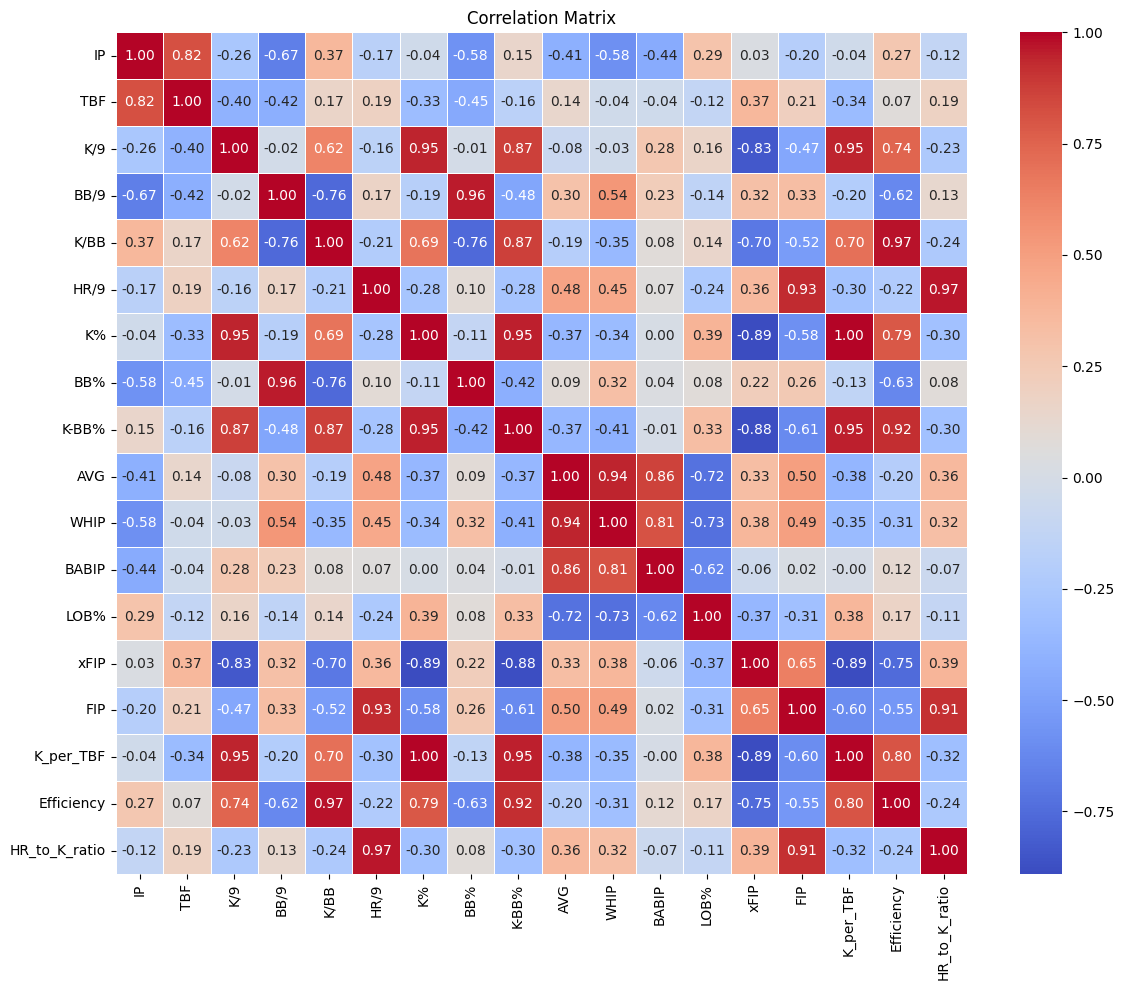


Training set: (13, 17), Test set: (4, 17)

Model Performance:
Training RMSE: 0.0124
Test RMSE: 1.2434
Training R²: 1.0000
Test R²: -3.0314
Test MAE: 1.0504


<Figure size 1200x600 with 0 Axes>

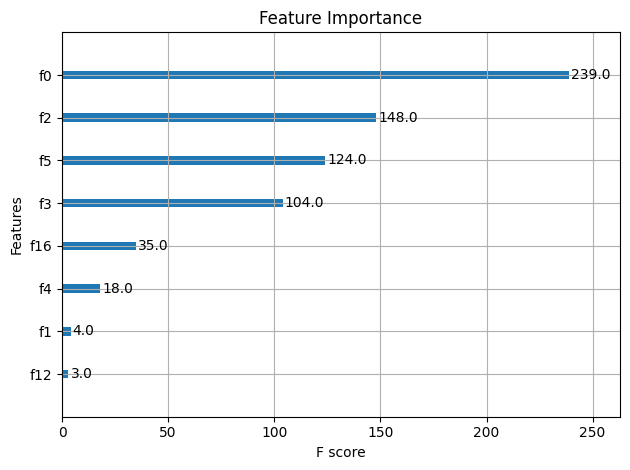


Sample Prediction for Next Game:
Predicted FIP: 2.84
Actual FIP: 2.45
Difference: 0.39

Model and scaler saved successfully.

Predictions for Upcoming Games:
   Actual_FIP  Predicted_FIP
0    2.452194       2.839266
1    1.452194       3.602468
2    2.999813       3.945235
3    1.666480       0.947497

Model ready for deployment!


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Splits Leaderboard Data as SP Away.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Verify Required Columns ==========
# Updated to use FIP as the target variable
target = 'FIP'
# Removing FIP from features since it's now the target
features = ['IP', 'TBF', 'K/9', 'BB/9', 'K/BB', 'HR/9', 'K%', 'BB%', 'K-BB%', 'AVG', 'WHIP', 'BABIP', 'LOB%', 'xFIP']

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 3: Data Preprocessing ==========
# Convert percentage strings to floats if needed
percentage_cols = [col for col in df.columns if '%' in col]
for col in percentage_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.rstrip('%').astype('float') / 100.0

# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
df = df[df['IP'] > 0]  # Ensure pitcher has pitched at least some innings

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Create any additional features that might help prediction
# Example: Calculate efficiency metrics
model_df['K_per_TBF'] = model_df['K/9'] / (model_df['TBF'] / model_df['IP'] * 9)
model_df['Efficiency'] = model_df['K/BB'] * model_df['K/9']
# New feature specifically for FIP prediction
model_df['HR_to_K_ratio'] = model_df['HR/9'] / model_df['K/9']

# Replace infinite values with NaN
model_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN values (you can choose a different strategy if needed)
model_df.fillna(model_df.median(), inplace=True)

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print(f"\nFeature correlations with {target}:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Optional: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (commented out to save computation time)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ========== Step 11: Predictions for Next Game ==========
# Function to predict FIP for a specific pitcher
def predict_next_game_fip(pitcher_data, model, scaler):
    """
    Predict next game FIP for a pitcher based on their stats

    Args:
        pitcher_data: DataFrame row or dict containing pitcher's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted FIP for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(pitcher_data, dict):
        pitcher_df = pd.DataFrame([pitcher_data])
    else:
        pitcher_df = pd.DataFrame([pitcher_data])

    # Apply same feature engineering as training data
    pitcher_df['K_per_TBF'] = pitcher_df['K/9'] / (pitcher_df['TBF'] / pitcher_df['IP'] * 9)
    pitcher_df['Efficiency'] = pitcher_df['K/BB'] * pitcher_df['K/9']
    pitcher_df['HR_to_K_ratio'] = pitcher_df['HR/9'] / pitcher_df['K/9']

    # Scale features
    scaled_features = scaler.transform(pitcher_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    return prediction

# Example: Predicting for a sample pitcher
# (This would be replaced with actual pitcher data)
sample_pitcher = X_test.iloc[0].to_dict()  # Using first test set example
predicted_fip = predict_next_game_fip(sample_pitcher, xgb_model, scaler)
actual_fip = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted FIP: {predicted_fip:.2f}")
print(f"Actual FIP: {actual_fip:.2f}")
print(f"Difference: {abs(predicted_fip - actual_fip):.2f}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('mlb_pitcher_fip_model.json')
import joblib
joblib.dump(scaler, 'fip_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 13: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple pitchers
def predict_upcoming_games(pitchers_df, model, scaler):
    """
    Make FIP predictions for multiple upcoming pitchers

    Args:
        pitchers_df: DataFrame with upcoming pitchers stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = pitchers_df.copy()

    # Apply same feature engineering
    result_df['K_per_TBF'] = result_df['K/9'] / (result_df['TBF'] / result_df['IP'] * 9)
    result_df['Efficiency'] = result_df['K/BB'] * result_df['K/9']
    result_df['HR_to_K_ratio'] = result_df['HR/9'] / result_df['K/9']

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result
    result_df['Predicted_FIP'] = predictions

    return result_df

# Example: Predict for a sample of upcoming pitchers
# (This would be replaced with actual upcoming pitcher data)
sample_upcoming_pitchers = X_test.head(5).copy()  # Using first 5 test examples
predictions_df = predict_upcoming_games(sample_upcoming_pitchers, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
comparison_df = pd.DataFrame({
    'Actual_FIP': y_test.head(5).values,
    'Predicted_FIP': predictions_df['Predicted_FIP'].values
})
print(comparison_df)

print("\nModel ready for deployment!")

Data loaded successfully. Shape: (137, 17)

Missing values per column:
K/9      0
K/BB     0
K-BB%    0
LOB%     0
HR/9     0
BABIP    0
IP       0
K%       0
dtype: int64

Preprocessed data shape: (133, 8)

Feature correlations with K%:
K%            1.000000
k_per_TBF     0.995049
K/9           0.901771
K-BB%         0.833103
efficiency    0.807979
K/BB          0.708741
LOB%          0.315967
IP            0.106728
HR/9         -0.113277
BABIP        -0.191050
Name: K%, dtype: float64


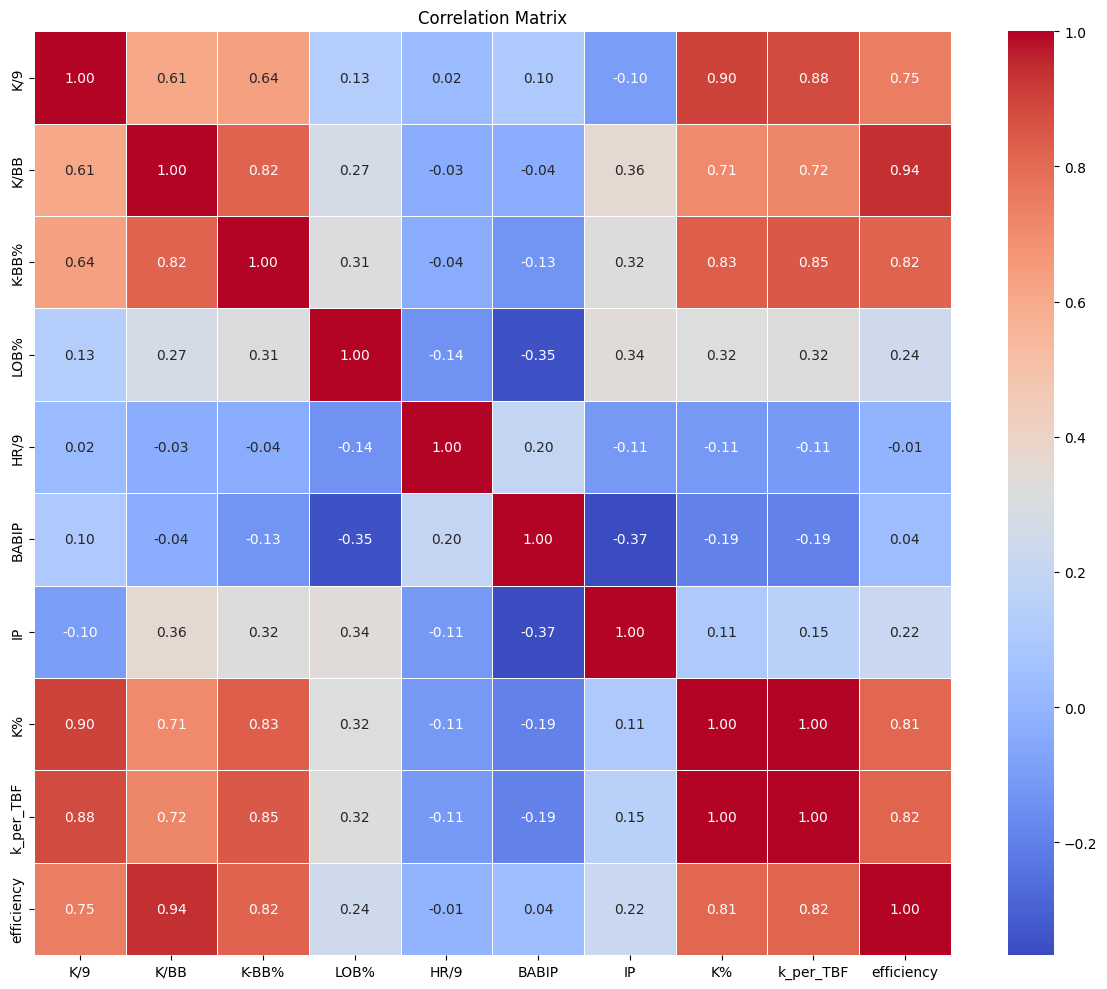


Training set: (106, 9), Test set: (27, 9)

Model Performance:
Training RMSE: 0.0016
Test RMSE: 0.0089
Training R²: 0.9998
Test R²: 0.9912
Test MAE: 0.0072


<Figure size 1200x600 with 0 Axes>

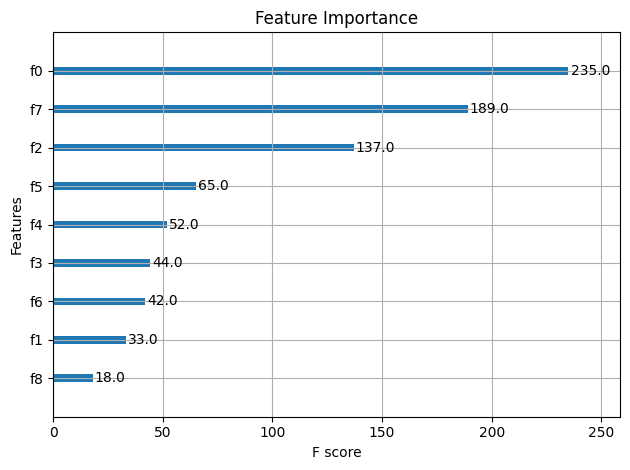


Sample Prediction for Next Game:
Predicted K%: 29.61%
Actual K%: 31.25%
Difference: 1.64%

Model and scaler saved successfully.

Predictions for Upcoming Games:
   Actual_K%  Predicted_K%
0   0.312500      0.296123
1   0.071429      0.080484
2   0.217391      0.208216
3   0.080000      0.084081
4   0.263158      0.263762

Model ready for deployment!


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Splits Leaderboard Data as SP vs BAL as RHP.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Define Required Columns ==========
# Updated to use only the specified features
features = ['K/9', 'K/BB', 'K-BB%', 'LOB%', 'HR/9', 'BABIP', 'IP']
target = 'K%'

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 3: Data Preprocessing ==========
# Convert percentage strings to floats if needed
percentage_cols = [col for col in df.columns if '%' in col]
for col in percentage_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.rstrip('%').astype('float') / 100.0

# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
df = df[df['IP'] > 0]  # Ensure pitcher has pitched at least some innings

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Calculate k_per_TBF
# Note: We need TBF to calculate k_per_TBF, so we'll check if it exists or derive it
if 'TBF' in df.columns:
    model_df['k_per_TBF'] = df['K/9'] / (df['TBF'] / df['IP'] * 9)
else:
    # Approximating TBF if not available using K/9 and BB/9
    # This is a rough estimation
    if 'BB/9' in df.columns:
        estimated_TBF = df['IP'] * ((df['K/9'] + df['BB/9']) / 9 + 3)  # Rough estimate of batters faced
        model_df['k_per_TBF'] = df['K/9'] / (estimated_TBF / df['IP'] * 9)
    else:
        print("Warning: Cannot calculate k_per_TBF without TBF or BB/9 data")
        model_df['k_per_TBF'] = df['K/9'] / 9  # Fallback calculation

# Calculate efficiency
model_df['efficiency'] = model_df['K/BB'] * model_df['K/9']

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with K%:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (commented out to save computation time)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ========== Step 11: Predictions for Next Game ==========
# Function to predict K% for a specific pitcher
def predict_next_game_k_percent(pitcher_data, model, scaler):
    """
    Predict next game K% for a pitcher based on their stats

    Args:
        pitcher_data: DataFrame row or dict containing pitcher's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted K% for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(pitcher_data, dict):
        pitcher_df = pd.DataFrame([pitcher_data])
    else:
        pitcher_df = pd.DataFrame([pitcher_data])

    # Make sure we have all required features
    for feature in X_train.columns:
        if feature not in pitcher_df.columns:
            if feature == 'k_per_TBF':
                # Calculate k_per_TBF if missing
                if 'TBF' in pitcher_df.columns:
                    pitcher_df['k_per_TBF'] = pitcher_df['K/9'] / (pitcher_df['TBF'] / pitcher_df['IP'] * 9)
                else:
                    # Approximate if TBF is not available
                    pitcher_df['k_per_TBF'] = pitcher_df['K/9'] / 9
            elif feature == 'efficiency':
                # Calculate efficiency if missing
                pitcher_df['efficiency'] = pitcher_df['K/BB'] * pitcher_df['K/9']
            else:
                raise ValueError(f"Missing required feature: {feature}")

    # Extract features in the correct order
    features_df = pitcher_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    return prediction

# Example: Predicting for a sample pitcher
# (This would be replaced with actual pitcher data)
sample_pitcher = X_test.iloc[0].to_dict()  # Using first test set example
predicted_k_percent = predict_next_game_k_percent(sample_pitcher, xgb_model, scaler)
actual_k_percent = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted K%: {predicted_k_percent:.2%}")
print(f"Actual K%: {actual_k_percent:.2%}")
print(f"Difference: {abs(predicted_k_percent - actual_k_percent):.2%}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('mlb_pitcher_k_percent_model.json')
import joblib
joblib.dump(scaler, 'k_percent_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 13: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple pitchers
def predict_upcoming_games(pitchers_df, model, scaler):
    """
    Make K% predictions for multiple upcoming pitchers

    Args:
        pitchers_df: DataFrame with upcoming pitchers stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = pitchers_df.copy()

    # Calculate required features if they don't exist
    if 'k_per_TBF' not in result_df.columns:
        if 'TBF' in result_df.columns:
            result_df['k_per_TBF'] = result_df['K/9'] / (result_df['TBF'] / result_df['IP'] * 9)
        else:
            # Approximate if TBF is not available
            result_df['k_per_TBF'] = result_df['K/9'] / 9

    if 'efficiency' not in result_df.columns:
        result_df['efficiency'] = result_df['K/BB'] * result_df['K/9']

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result
    result_df['Predicted_K%'] = predictions

    return result_df

# Example: Predict for a sample of upcoming pitchers
# (This would be replaced with actual upcoming pitcher data)
sample_upcoming_pitchers = X_test.head(5).copy()  # Using first 5 test examples
predictions_df = predict_upcoming_games(sample_upcoming_pitchers, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
comparison_df = pd.DataFrame({
    'Actual_K%': y_test.head(5).values,
    'Predicted_K%': predictions_df['Predicted_K%'].values
})
print(comparison_df)

print("\nModel ready for deployment!")

Data loaded successfully. Shape: (126, 17)

Missing values per column:
K/9      0
K/BB     0
K-BB%    0
LOB%     0
HR/9     0
BABIP    0
IP       0
K%       0
dtype: int64

Preprocessed data shape: (126, 8)

Feature correlations with K%:
K%            1.000000
k_per_TBF     0.997393
K/9           0.939636
K-BB%         0.867162
efficiency    0.839400
K/BB          0.714546
LOB%          0.245877
IP            0.139090
HR/9         -0.029315
BABIP        -0.055447
Name: K%, dtype: float64


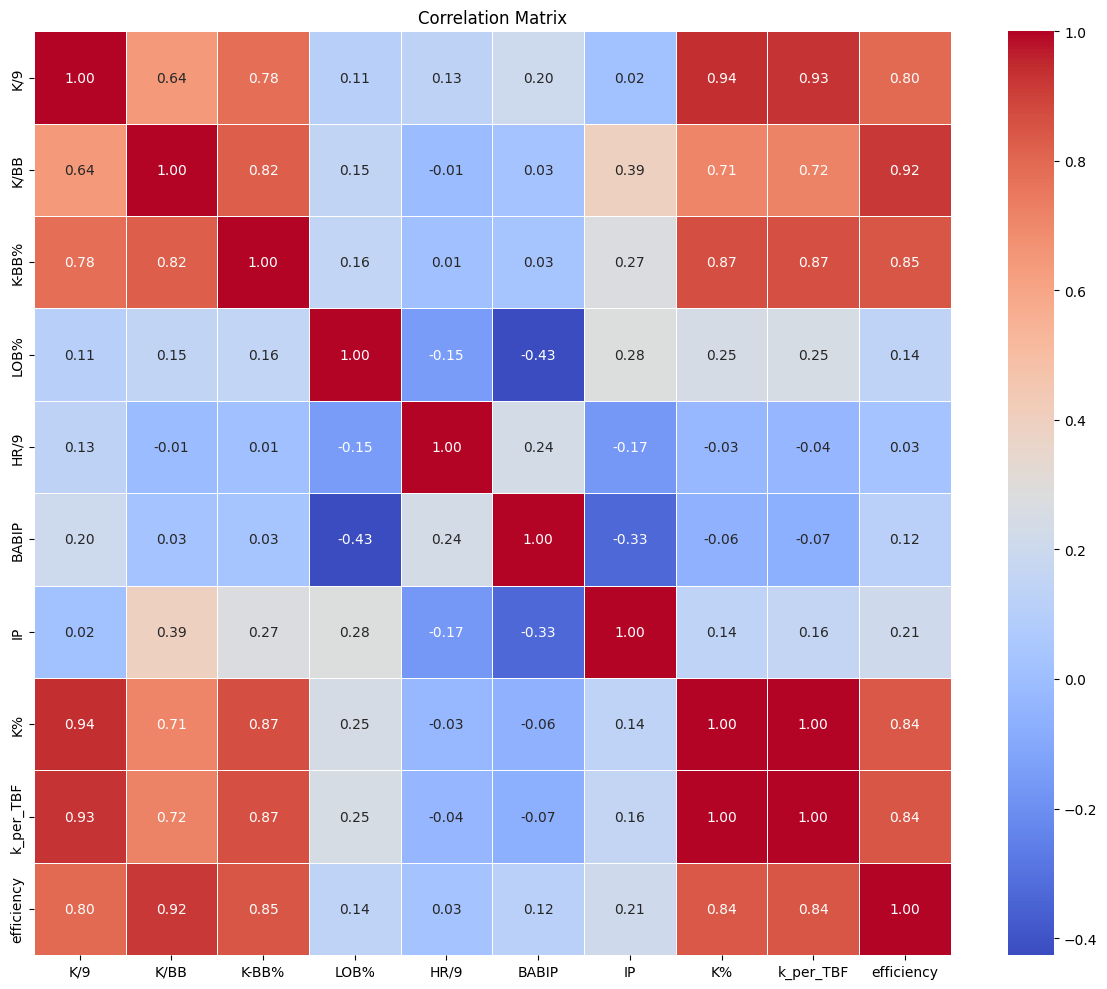


Training set: (100, 9), Test set: (26, 9)

Model Performance:
Training RMSE: 0.0014
Test RMSE: 0.0250
Training R²: 0.9998
Test R²: 0.9656
Test MAE: 0.0117


<Figure size 1200x600 with 0 Axes>

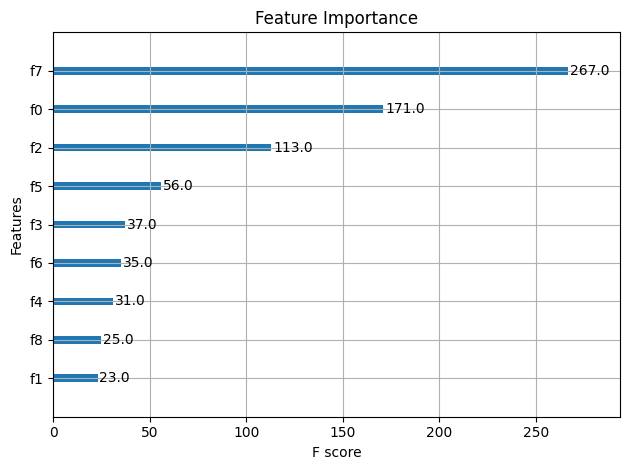


Sample Prediction for Next Game:
Predicted K%: 54.78%
Actual K%: 66.67%
Difference: 11.89%

Model and scaler saved successfully.

Predictions for Upcoming Games:
   Actual_K%  Predicted_K%
0   0.666667      0.547769
1   0.111111      0.119521
2   0.200000      0.202460
3   0.227273      0.234157
4   0.277778      0.268159

Model ready for deployment!


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Splits Leaderboard Data as SP vs BAL as RHP Home.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Define Required Columns ==========
# Updated to use only the specified features
features = ['K/9', 'K/BB', 'K-BB%', 'LOB%', 'HR/9', 'BABIP', 'IP']
target = 'K%'

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 3: Data Preprocessing ==========
# Convert percentage strings to floats if needed
percentage_cols = [col for col in df.columns if '%' in col]
for col in percentage_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.rstrip('%').astype('float') / 100.0

# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
df = df[df['IP'] > 0]  # Ensure pitcher has pitched at least some innings

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Calculate k_per_TBF
# Note: We need TBF to calculate k_per_TBF, so we'll check if it exists or derive it
if 'TBF' in df.columns:
    model_df['k_per_TBF'] = df['K/9'] / (df['TBF'] / df['IP'] * 9)
else:
    # Approximating TBF if not available using K/9 and BB/9
    # This is a rough estimation
    if 'BB/9' in df.columns:
        estimated_TBF = df['IP'] * ((df['K/9'] + df['BB/9']) / 9 + 3)  # Rough estimate of batters faced
        model_df['k_per_TBF'] = df['K/9'] / (estimated_TBF / df['IP'] * 9)
    else:
        print("Warning: Cannot calculate k_per_TBF without TBF or BB/9 data")
        model_df['k_per_TBF'] = df['K/9'] / 9  # Fallback calculation

# Calculate efficiency
model_df['efficiency'] = model_df['K/BB'] * model_df['K/9']

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with K%:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (commented out to save computation time)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ========== Step 11: Predictions for Next Game ==========
# Function to predict K% for a specific pitcher
def predict_next_game_k_percent(pitcher_data, model, scaler):
    """
    Predict next game K% for a pitcher based on their stats

    Args:
        pitcher_data: DataFrame row or dict containing pitcher's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted K% for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(pitcher_data, dict):
        pitcher_df = pd.DataFrame([pitcher_data])
    else:
        pitcher_df = pd.DataFrame([pitcher_data])

    # Make sure we have all required features
    for feature in X_train.columns:
        if feature not in pitcher_df.columns:
            if feature == 'k_per_TBF':
                # Calculate k_per_TBF if missing
                if 'TBF' in pitcher_df.columns:
                    pitcher_df['k_per_TBF'] = pitcher_df['K/9'] / (pitcher_df['TBF'] / pitcher_df['IP'] * 9)
                else:
                    # Approximate if TBF is not available
                    pitcher_df['k_per_TBF'] = pitcher_df['K/9'] / 9
            elif feature == 'efficiency':
                # Calculate efficiency if missing
                pitcher_df['efficiency'] = pitcher_df['K/BB'] * pitcher_df['K/9']
            else:
                raise ValueError(f"Missing required feature: {feature}")

    # Extract features in the correct order
    features_df = pitcher_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    return prediction

# Example: Predicting for a sample pitcher
# (This would be replaced with actual pitcher data)
sample_pitcher = X_test.iloc[0].to_dict()  # Using first test set example
predicted_k_percent = predict_next_game_k_percent(sample_pitcher, xgb_model, scaler)
actual_k_percent = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted K%: {predicted_k_percent:.2%}")
print(f"Actual K%: {actual_k_percent:.2%}")
print(f"Difference: {abs(predicted_k_percent - actual_k_percent):.2%}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('mlb_pitcher_k_percent_model.json')
import joblib
joblib.dump(scaler, 'k_percent_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 13: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple pitchers
def predict_upcoming_games(pitchers_df, model, scaler):
    """
    Make K% predictions for multiple upcoming pitchers

    Args:
        pitchers_df: DataFrame with upcoming pitchers stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = pitchers_df.copy()

    # Calculate required features if they don't exist
    if 'k_per_TBF' not in result_df.columns:
        if 'TBF' in result_df.columns:
            result_df['k_per_TBF'] = result_df['K/9'] / (result_df['TBF'] / result_df['IP'] * 9)
        else:
            # Approximate if TBF is not available
            result_df['k_per_TBF'] = result_df['K/9'] / 9

    if 'efficiency' not in result_df.columns:
        result_df['efficiency'] = result_df['K/BB'] * result_df['K/9']

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result
    result_df['Predicted_K%'] = predictions

    return result_df

# Example: Predict for a sample of upcoming pitchers
# (This would be replaced with actual upcoming pitcher data)
sample_upcoming_pitchers = X_test.head(5).copy()  # Using first 5 test examples
predictions_df = predict_upcoming_games(sample_upcoming_pitchers, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
comparison_df = pd.DataFrame({
    'Actual_K%': y_test.head(5).values,
    'Predicted_K%': predictions_df['Predicted_K%'].values
})
print(comparison_df)

print("\nModel ready for deployment!")

Data loaded successfully. Shape: (63, 17)

Missing values per column:
K/9      0
K/BB     0
K-BB%    0
LOB%     0
HR/9     0
BABIP    0
IP       0
K%       0
TBF      0
dtype: int64

Preprocessed data shape: (63, 9)

Feature correlations with TBF:
TBF           1.000000
IP            0.789337
LOB%          0.160606
K/BB          0.081629
HR/9          0.014800
K-BB%        -0.029222
K%           -0.127073
K/9          -0.209901
TBF_per_IP   -0.221474
BABIP        -0.245818
Name: TBF, dtype: float64


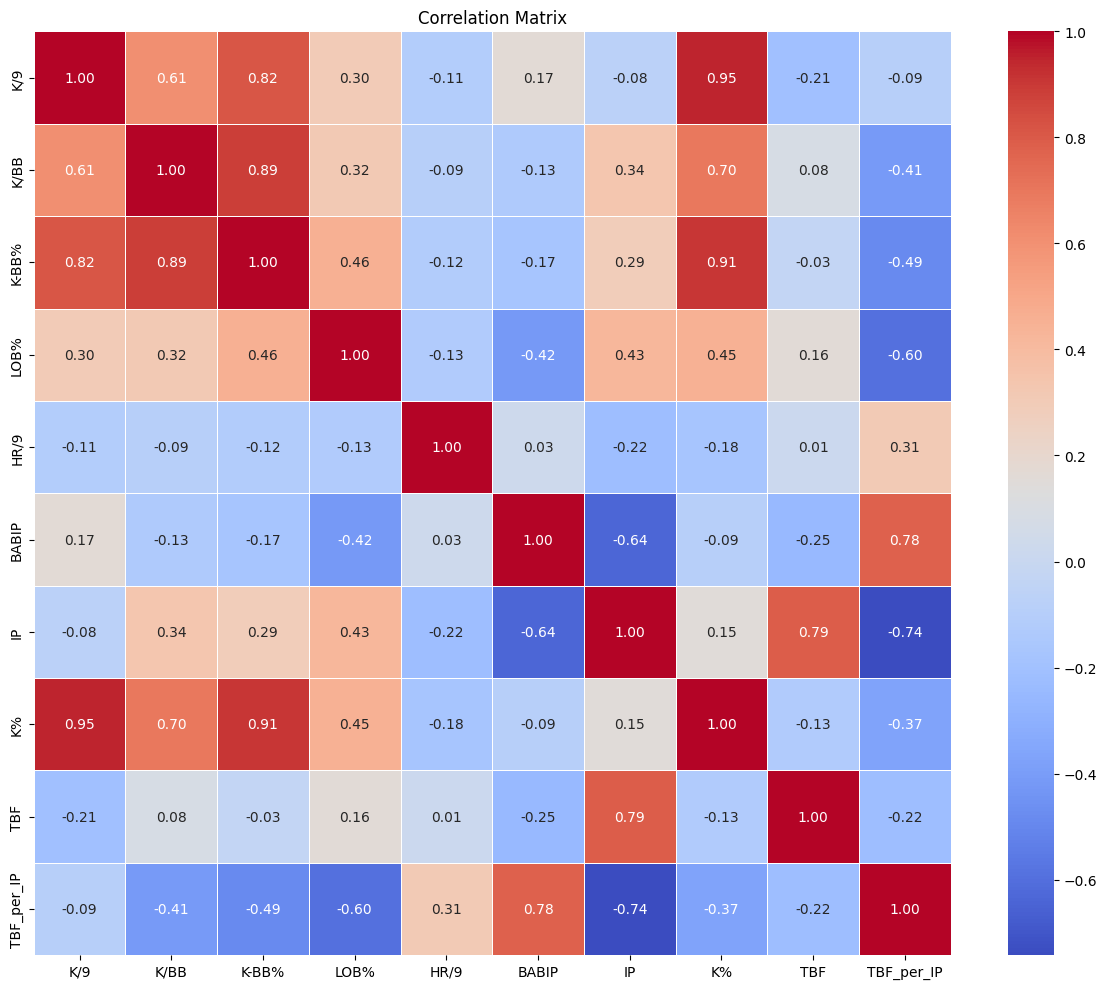

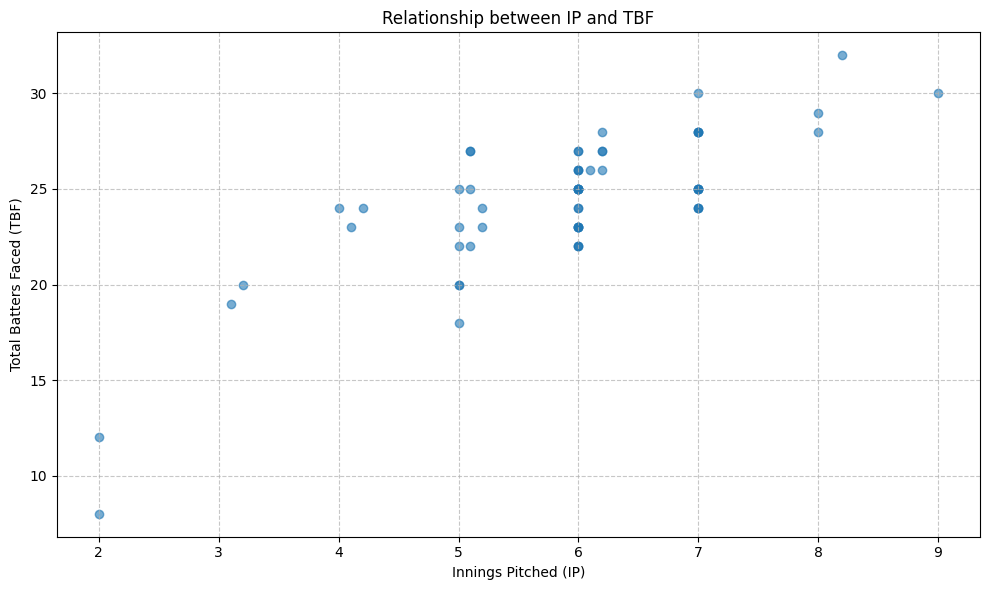


Training set: (50, 9), Test set: (13, 9)

Model Performance:
Training RMSE: 0.0687
Test RMSE: 3.0496
Training R²: 0.9997
Test R²: -0.0180
Test MAE: 2.1588


<Figure size 1200x600 with 0 Axes>

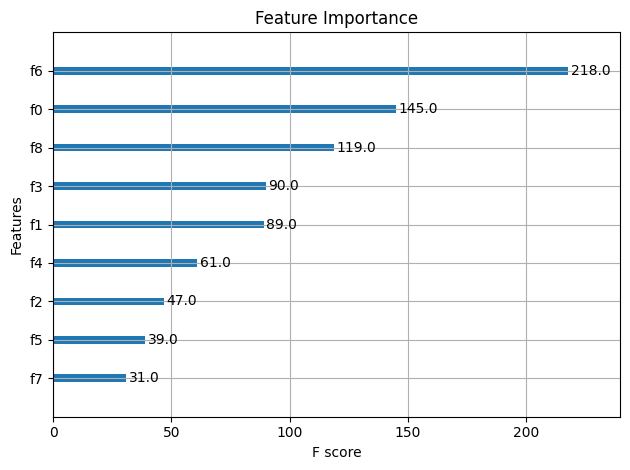


Sample Prediction for Next Game:
Predicted TBF: 26
Actual TBF: 23
Difference: 3

Model and scaler saved successfully.

Predictions for Upcoming Games:
   Actual_TBF  Predicted_TBF
0          23             26
1          25             29
2          25             25
3          23             23
4          25             25

Batch Prediction MAE: 1.40 batters
Batch Prediction RMSE: 2.24 batters

Model ready for deployment!

Estimated Game Impact:
Estimated Innings: 5.9
Estimated Strikeouts: 7
Estimated Walks: 2
Estimated Hits: 7


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Splits Leaderboard Data -18.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Define Required Columns ==========
# Updated to use appropriate features for TBF prediction
features = ['K/9', 'K/BB', 'K-BB%', 'LOB%', 'HR/9', 'BABIP', 'IP', 'K%']
target = 'TBF'  # Changed target to TBF

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 3: Data Preprocessing ==========
# Convert percentage strings to floats if needed
percentage_cols = [col for col in df.columns if '%' in col]
for col in percentage_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.rstrip('%').astype('float') / 100.0

# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
df = df[df['IP'] > 0]  # Ensure pitcher has pitched at least some innings

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Calculate innings per game if we have game data
if 'G' in df.columns:
    model_df['IP_per_G'] = df['IP'] / df['G']
else:
    print("Warning: Cannot calculate IP_per_G without games (G) data")

# Calculate TBF per inning
model_df['TBF_per_IP'] = df['TBF'] / df['IP']

# Calculate expected TBF (eTBF) based on standard metrics
# TBF is approximately 3 outs per inning + baserunners
if 'BB/9' in df.columns and 'H/9' in df.columns:
    model_df['eTBF'] = df['IP'] * (3 + (df['BB/9'] + df['H/9']) / 9)
else:
    print("Warning: Cannot calculate eTBF without BB/9 and H/9 data")

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with TBF:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# Plot relationship between IP and TBF
plt.figure(figsize=(10, 6))
plt.scatter(model_df['IP'], model_df['TBF'], alpha=0.6)
plt.title('Relationship between IP and TBF')
plt.xlabel('Innings Pitched (IP)')
plt.ylabel('Total Batters Faced (TBF)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (commented out to save computation time)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ========== Step 11: Predictions for Next Game ==========
# Function to predict TBF for a specific pitcher
def predict_next_game_tbf(pitcher_data, model, scaler):
    """
    Predict next game TBF for a pitcher based on their stats

    Args:
        pitcher_data: DataFrame row or dict containing pitcher's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted TBF for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(pitcher_data, dict):
        pitcher_df = pd.DataFrame([pitcher_data])
    else:
        pitcher_df = pd.DataFrame([pitcher_data])

    # Make sure we have all required features
    for feature in X_train.columns:
        if feature not in pitcher_df.columns:
            if feature == 'TBF_per_IP':
                # Calculate TBF_per_IP if missing
                if 'TBF' in pitcher_df.columns and 'IP' in pitcher_df.columns:
                    pitcher_df['TBF_per_IP'] = pitcher_df['TBF'] / pitcher_df['IP']
                else:
                    # Estimate based on averages
                    pitcher_df['TBF_per_IP'] = 4.3  # MLB average
            elif feature == 'eTBF':
                # Approximate if not available
                if 'BB/9' in pitcher_df.columns and 'H/9' in pitcher_df.columns and 'IP' in pitcher_df.columns:
                    pitcher_df['eTBF'] = pitcher_df['IP'] * (3 + (pitcher_df['BB/9'] + pitcher_df['H/9']) / 9)
                else:
                    pitcher_df['eTBF'] = pitcher_df['IP'] * 4.3  # MLB average
            elif feature == 'IP_per_G':
                if 'G' in pitcher_df.columns and 'IP' in pitcher_df.columns:
                    pitcher_df['IP_per_G'] = pitcher_df['IP'] / pitcher_df['G']
                else:
                    pitcher_df['IP_per_G'] = 5.5  # Typical starter innings per game
            else:
                raise ValueError(f"Missing required feature: {feature}")

    # Extract features in the correct order
    features_df = pitcher_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    # TBF should be a whole number
    return round(prediction)

# Example: Predicting for a sample pitcher
# (This would be replaced with actual pitcher data)
sample_pitcher = X_test.iloc[0].to_dict()  # Using first test set example
predicted_tbf = predict_next_game_tbf(sample_pitcher, xgb_model, scaler)
actual_tbf = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted TBF: {predicted_tbf}")
print(f"Actual TBF: {actual_tbf}")
print(f"Difference: {abs(predicted_tbf - actual_tbf)}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('mlb_pitcher_tbf_model.json')
import joblib
joblib.dump(scaler, 'tbf_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 13: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple pitchers
def predict_upcoming_games_tbf(pitchers_df, model, scaler):
    """
    Make TBF predictions for multiple upcoming pitchers

    Args:
        pitchers_df: DataFrame with upcoming pitchers stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = pitchers_df.copy()

    # Calculate required features if they don't exist
    if 'TBF_per_IP' not in result_df.columns:
        if 'TBF' in result_df.columns and 'IP' in result_df.columns:
            result_df['TBF_per_IP'] = result_df['TBF'] / result_df['IP']
        else:
            result_df['TBF_per_IP'] = 4.3  # MLB average

    if 'eTBF' not in result_df.columns:
        if 'BB/9' in result_df.columns and 'H/9' in result_df.columns:
            result_df['eTBF'] = result_df['IP'] * (3 + (result_df['BB/9'] + result_df['H/9']) / 9)
        else:
            result_df['eTBF'] = result_df['IP'] * 4.3

    if 'IP_per_G' not in result_df.columns:
        if 'G' in result_df.columns:
            result_df['IP_per_G'] = result_df['IP'] / result_df['G']
        else:
            result_df['IP_per_G'] = 5.5  # Typical starter innings per game

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result (round to whole numbers for TBF)
    result_df['Predicted_TBF'] = np.round(predictions).astype(int)

    return result_df

# Example: Predict for a sample of upcoming pitchers
# (This would be replaced with actual upcoming pitcher data)
sample_upcoming_pitchers = X_test.head(5).copy()  # Using first 5 test examples
predictions_df = predict_upcoming_games_tbf(sample_upcoming_pitchers, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
comparison_df = pd.DataFrame({
    'Actual_TBF': y_test.head(5).values.astype(int),
    'Predicted_TBF': predictions_df['Predicted_TBF'].values
})
print(comparison_df)

# Calculate accuracy metrics for batch predictions
batch_mae = mean_absolute_error(comparison_df['Actual_TBF'], comparison_df['Predicted_TBF'])
batch_rmse = np.sqrt(mean_squared_error(comparison_df['Actual_TBF'], comparison_df['Predicted_TBF']))
print(f"\nBatch Prediction MAE: {batch_mae:.2f} batters")
print(f"Batch Prediction RMSE: {batch_rmse:.2f} batters")

print("\nModel ready for deployment!")

# ========== Step 14: TBF to Game Impact Analysis ==========
# Function to estimate game impact based on TBF prediction
def analyze_tbf_impact(predicted_tbf, pitcher_stats):
    """
    Analyze the game impact of predicted TBF

    Args:
        predicted_tbf: Predicted TBF value
        pitcher_stats: Dictionary or Series with pitcher stats

    Returns:
        Dictionary with estimated impact metrics
    """
    # Calculate estimated innings
    if 'TBF_per_IP' in pitcher_stats:
        est_innings = predicted_tbf / pitcher_stats['TBF_per_IP']
    else:
        # Use MLB average of about 4.3 batters per inning
        est_innings = predicted_tbf / 4.3

    # Calculate estimated strikeouts
    if 'K%' in pitcher_stats:
        est_strikeouts = predicted_tbf * pitcher_stats['K%']
    elif 'K/9' in pitcher_stats:
        est_strikeouts = pitcher_stats['K/9'] * (est_innings / 9)
    else:
        est_strikeouts = predicted_tbf * 0.23  # MLB average K%

    # Calculate estimated walks
    if 'BB%' in pitcher_stats:
        est_walks = predicted_tbf * pitcher_stats['BB%']
    elif 'BB/9' in pitcher_stats:
        est_walks = pitcher_stats['BB/9'] * (est_innings / 9)
    else:
        est_walks = predicted_tbf * 0.08  # MLB average BB%

    # Calculate estimated hits
    if 'BABIP' in pitcher_stats and 'K%' in pitcher_stats:
        # Balls in play = TBF - K - BB - HBP
        balls_in_play = predicted_tbf * (1 - pitcher_stats['K%'] - (pitcher_stats.get('BB%', 0.08)))
        est_hits = balls_in_play * pitcher_stats['BABIP']
    else:
        # Rough estimate
        est_hits = predicted_tbf * 0.22  # MLB average hit rate

    return {
        'estimated_innings': round(est_innings, 1),
        'estimated_strikeouts': round(est_strikeouts),
        'estimated_walks': round(est_walks),
        'estimated_hits': round(est_hits)
    }

# Example analysis for the sample pitcher
sample_impact = analyze_tbf_impact(predicted_tbf, sample_pitcher)
print("\nEstimated Game Impact:")
for metric, value in sample_impact.items():
    print(f"{metric.replace('_', ' ').title()}: {value}")

Data loaded successfully. Shape: (20, 19)

Missing values per column:
TBF     0
ERA     0
H       0
2B      0
3B      0
R       0
ER      0
HR      0
BB      0
IBB     0
HBP     0
AVG     0
OBP     0
SLG     0
wOBA    0
SO      0
dtype: int64

Preprocessed data shape: (20, 17)

Feature correlations with SO:
SO             1.000000
SO_per_TBF     0.895058
TBF            0.428799
HBP            0.218091
Date           0.131351
H              0.021238
ER            -0.097249
BB            -0.103633
BB_per_TBF    -0.119805
HR            -0.152078
SO_BB_ratio   -0.169033
HR_per_TBF    -0.171334
R             -0.242317
2B            -0.311890
ERA           -0.333599
H_per_TBF     -0.408282
OBP           -0.429405
AVG           -0.440697
wOBA          -0.479972
SLG           -0.482045
3B                  NaN
IBB                 NaN
Name: SO, dtype: float64


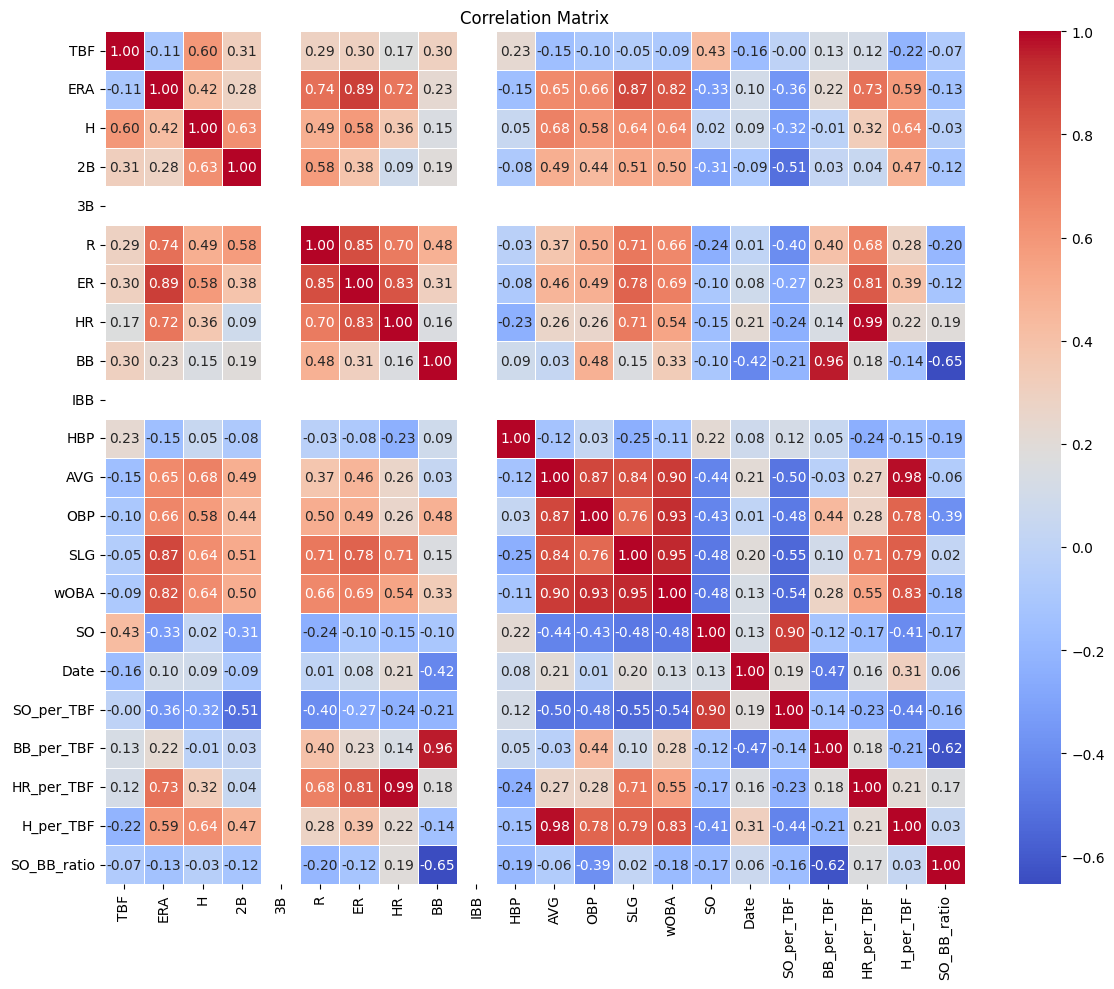


Time-based split - Training set: (16, 20), Test set: (4, 20)
Training period: 2025-03-27 00:00:00 to 2025-04-14 00:00:00
Testing period: 2025-04-15 00:00:00 to 2025-04-19 00:00:00


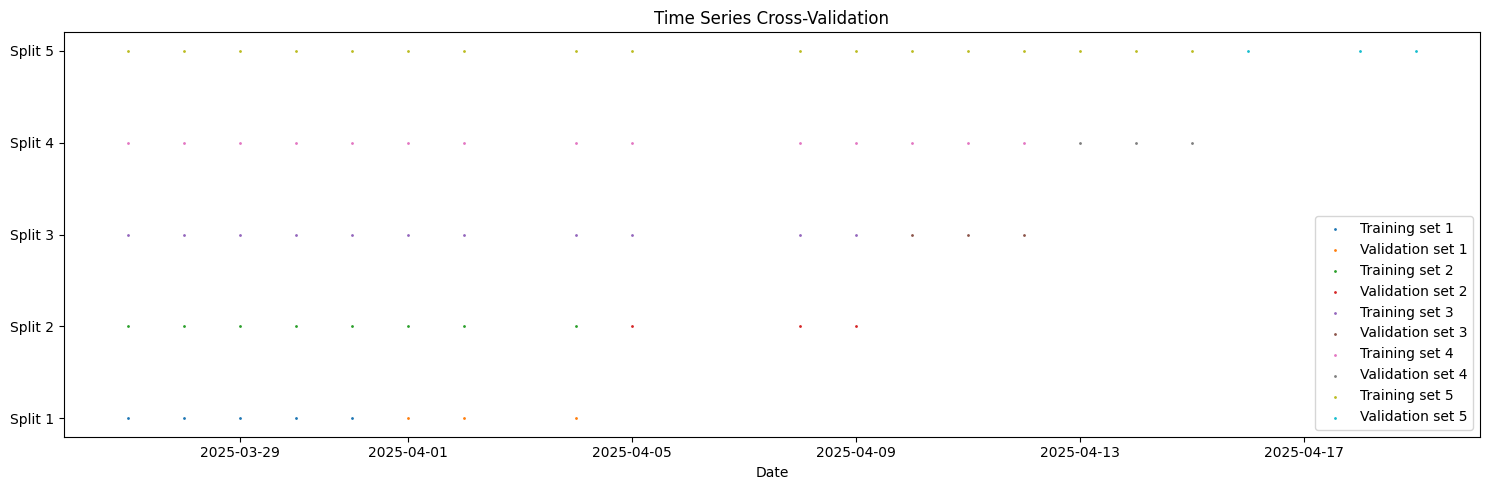


Performing Time Series Cross-Validation...

Fold 1/5
Training: 2025-03-27 00:00:00 to 2025-03-31 00:00:00 (5 samples)
Validation: 2025-04-01 00:00:00 to 2025-04-04 00:00:00 (3 samples)
Train RMSE: 0.0084, Validation RMSE: 3.1612
Train R²: 1.0000, Validation R²: -0.6060

Fold 2/5
Training: 2025-03-27 00:00:00 to 2025-04-04 00:00:00 (8 samples)
Validation: 2025-04-05 00:00:00 to 2025-04-09 00:00:00 (3 samples)
Train RMSE: 0.0069, Validation RMSE: 3.2168
Train R²: 1.0000, Validation R²: -5.6522

Fold 3/5
Training: 2025-03-27 00:00:00 to 2025-04-09 00:00:00 (11 samples)
Validation: 2025-04-10 00:00:00 to 2025-04-12 00:00:00 (3 samples)
Train RMSE: 0.0060, Validation RMSE: 1.2893
Train R²: 1.0000, Validation R²: -6.4807

Fold 4/5
Training: 2025-03-27 00:00:00 to 2025-04-12 00:00:00 (14 samples)
Validation: 2025-04-13 00:00:00 to 2025-04-15 00:00:00 (3 samples)
Train RMSE: 0.0091, Validation RMSE: 0.5995
Train R²: 1.0000, Validation R²: 0.8756

Fold 5/5
Training: 2025-03-27 00:00:00 to 2025

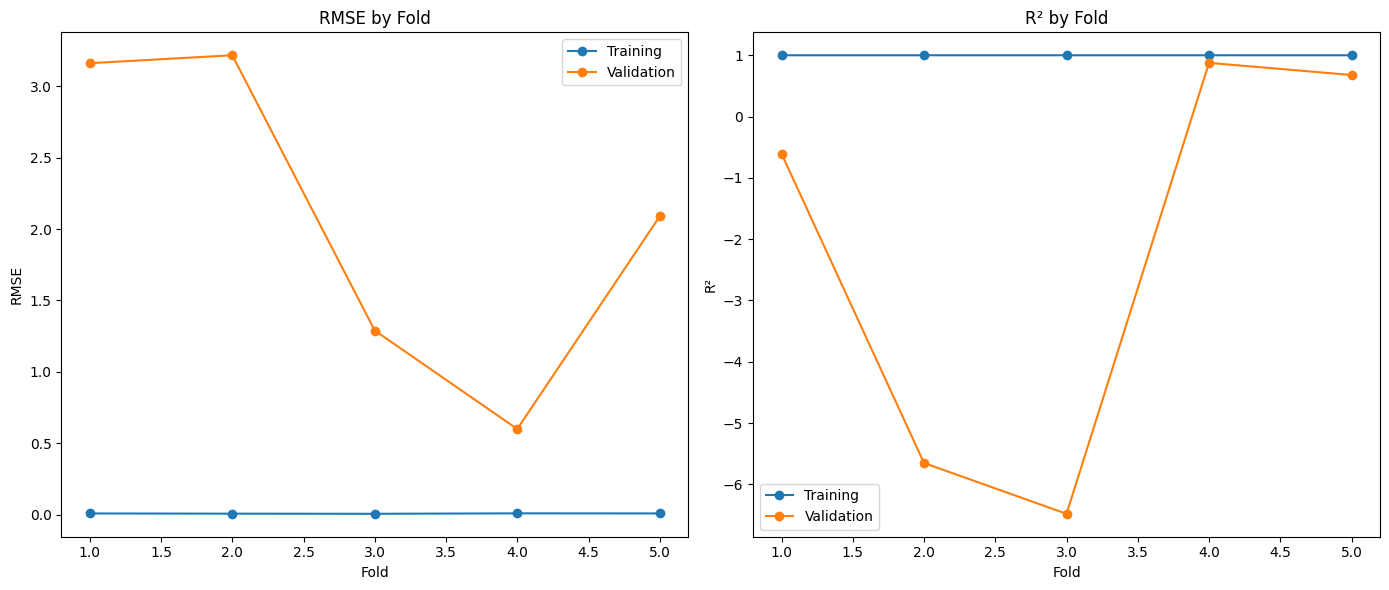


Final Model Performance:
Training RMSE: 0.0086
Test RMSE: 1.8175
Training R²: 1.0000
Test R²: 0.6758
Test MAE: 1.3075


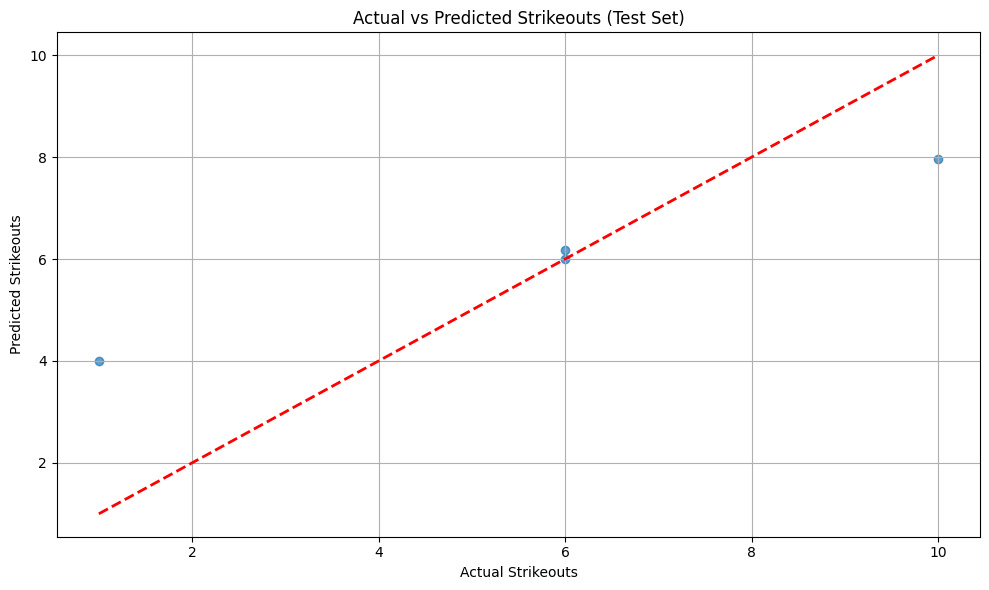

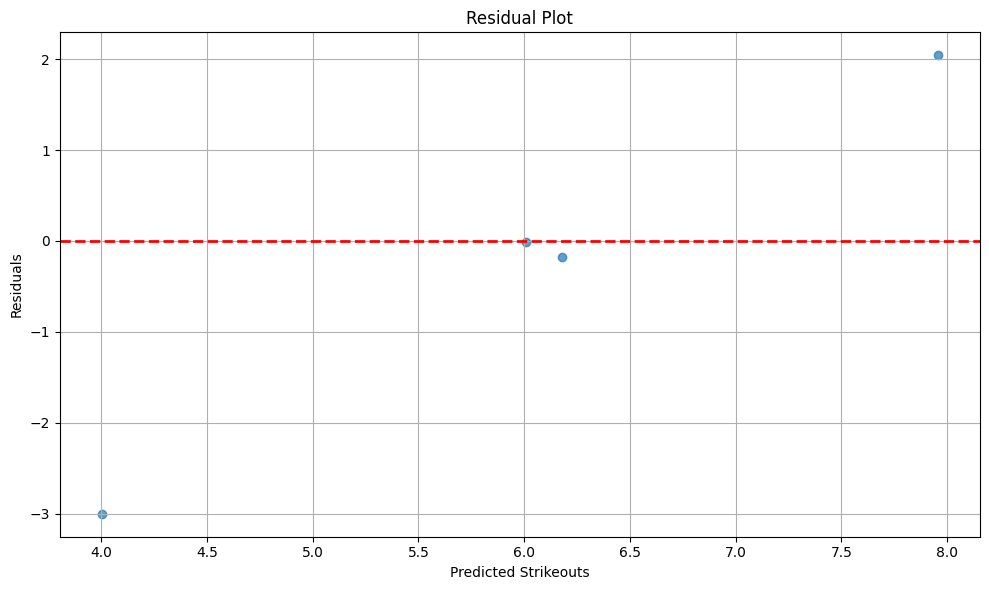

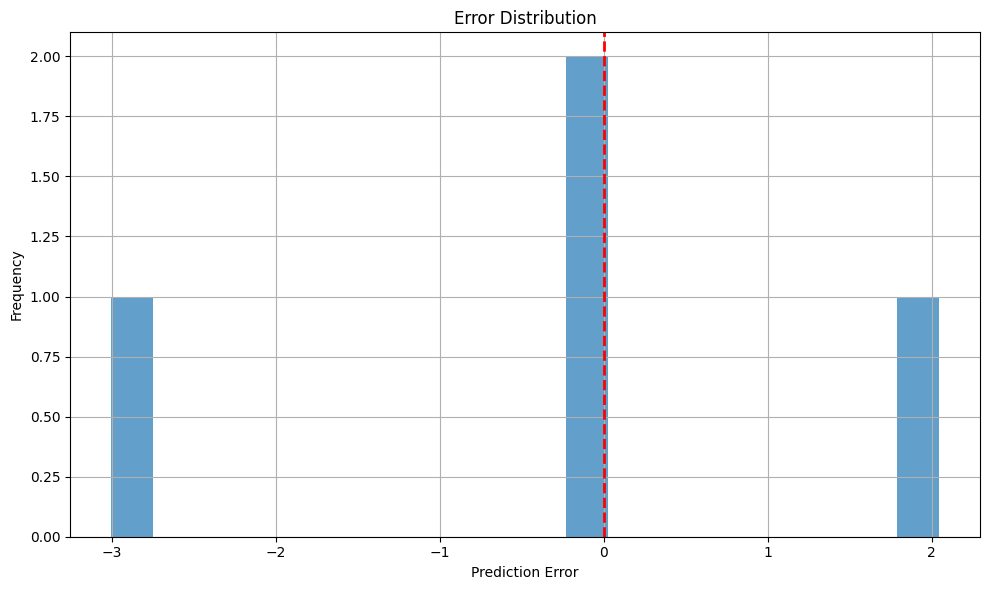

<Figure size 1200x800 with 0 Axes>

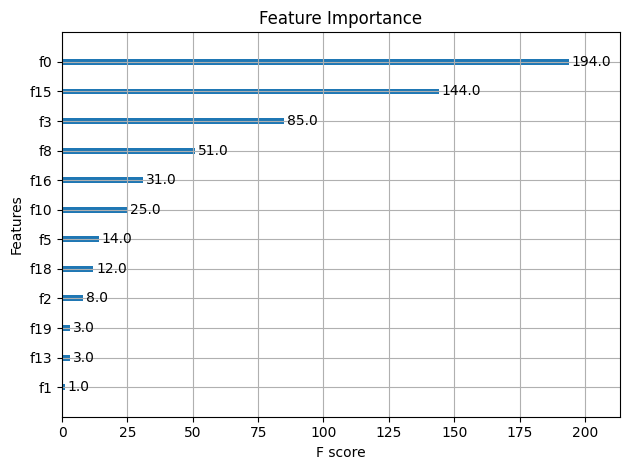


Sample Prediction for Next Game:
Predicted Strikeouts: 4.3
Actual Strikeouts: 6.0
Difference: 1.7

Model and scaler saved successfully.

Performing Walk-Forward Validation...

Walk-Forward Validation could not be performed due to insufficient data for validation sets.

Predictions for Upcoming Games:
        Date  Actual_SO  Predicted_SO
0 2025-04-15          6      4.253950
1 2025-04-16         10      3.967120
2 2025-04-18          6      3.964221
3 2025-04-19          1      4.001546

Model ready for deployment!


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Splits Leaderboard Data as SP vs ATL.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Verify Required Columns ==========
# Updated features list as requested
features = ['TBF', 'ERA', 'H', '2B', '3B', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'AVG', 'OBP', 'SLG', 'wOBA']
target = 'SO'  # New target variable

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# Check if date column exists for time series validation
# If not, create a dummy date column using index (assuming data is already in chronological order)
if 'Date' not in df.columns:
    print("Date column not found. Assuming data is already in chronological order.")
    df['Date'] = pd.date_range(start='2023-01-01', periods=len(df), freq='D')
else:
    # Ensure Date is in datetime format
    df['Date'] = pd.to_datetime(df['Date'])

# Sort by date to ensure chronological order
df = df.sort_values('Date')

# ========== Step 3: Data Preprocessing ==========
# Convert percentage strings to floats if needed
percentage_cols = ['AVG', 'OBP', 'SLG', 'wOBA']  # These might be stored as strings with %
for col in percentage_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.rstrip('%').astype('float') / 100.0

# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
df = df[df['TBF'] > 0]  # Ensure pitcher has faced at least some batters

# Create a copy of the dataframe with only the features we need plus Date
model_df = df[required_columns + ['Date']].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Create any additional features that might help prediction
# Example: Calculate efficiency metrics
model_df['SO_per_TBF'] = model_df['SO'] / model_df['TBF']
model_df['BB_per_TBF'] = model_df['BB'] / model_df['TBF']
model_df['HR_per_TBF'] = model_df['HR'] / model_df['TBF']
model_df['H_per_TBF'] = model_df['H'] / model_df['TBF']
model_df['SO_BB_ratio'] = model_df['SO'] / (model_df['BB'] + 0.01)  # Adding 0.01 to avoid division by zero

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with SO:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ========== Step 6: Time-Based Data Split ==========
# Split into features and target
X = model_df.drop([target, 'Date'], axis=1)
y = model_df[target]
dates = model_df['Date']

# Using a simple time-based train-test split first (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
dates_train, dates_test = dates.iloc[:train_size], dates.iloc[train_size:]

print(f"\nTime-based split - Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Training period: {dates_train.min()} to {dates_train.max()}")
print(f"Testing period: {dates_test.min()} to {dates_test.max()}")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Time Series Cross-Validation Setup ==========
# Set up TimeSeriesSplit for backtesting
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Prepare lists to store cross-validation metrics
cv_train_rmse = []
cv_val_rmse = []
cv_train_r2 = []
cv_val_r2 = []

# Function to evaluate model performance in each fold
def evaluate_fold(X_train_fold, y_train_fold, X_val_fold, y_val_fold):
    # Scale features
    scaler_fold = StandardScaler()
    X_train_fold_scaled = scaler_fold.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler_fold.transform(X_val_fold)

    # Initialize and train model
    fold_model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    )
    fold_model.fit(
        X_train_fold_scaled,
        y_train_fold,
        eval_set=[(X_val_fold_scaled, y_val_fold)],
        verbose=False
    )

    # Make predictions
    y_train_pred = fold_model.predict(X_train_fold_scaled)
    y_val_pred = fold_model.predict(X_val_fold_scaled)

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train_fold, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val_fold, y_val_pred))
    train_r2 = r2_score(y_train_fold, y_train_pred)
    val_r2 = r2_score(y_val_fold, y_val_pred)

    return train_rmse, val_rmse, train_r2, val_r2, fold_model

# Visualize the time series splits for better understanding
plt.figure(figsize=(15, 5))
for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    plt.scatter(dates.iloc[train_idx], [i + 0.5] * len(train_idx),
                s=1, label=f'Training set {i+1}')
    plt.scatter(dates.iloc[val_idx], [i + 0.5] * len(val_idx),
                s=1, label=f'Validation set {i+1}')

plt.yticks(np.arange(n_splits) + 0.5, [f'Split {i+1}' for i in range(n_splits)])
plt.title('Time Series Cross-Validation')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()
plt.show()

# ========== Step 8: Time Series Cross-Validation ==========
print("\nPerforming Time Series Cross-Validation...")
fold_results = []

# Perform time series cross-validation
for i, (train_idx, val_idx) in enumerate(tscv.split(X)):
    print(f"\nFold {i+1}/{n_splits}")

    # Split data
    X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
    y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

    train_start = dates.iloc[train_idx].min()
    train_end = dates.iloc[train_idx].max()
    val_start = dates.iloc[val_idx].min()
    val_end = dates.iloc[val_idx].max()

    print(f"Training: {train_start} to {train_end} ({len(X_train_fold)} samples)")
    print(f"Validation: {val_start} to {val_end} ({len(X_val_fold)} samples)")

    # Evaluate fold
    train_rmse, val_rmse, train_r2, val_r2, fold_model = evaluate_fold(
        X_train_fold, y_train_fold, X_val_fold, y_val_fold
    )

    # Store metrics
    cv_train_rmse.append(train_rmse)
    cv_val_rmse.append(val_rmse)
    cv_train_r2.append(train_r2)
    cv_val_r2.append(val_r2)

    # Store fold results
    fold_results.append({
        'fold': i+1,
        'train_size': len(X_train_fold),
        'val_size': len(X_val_fold),
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'train_r2': train_r2,
        'val_r2': val_r2
    })

    print(f"Train RMSE: {train_rmse:.4f}, Validation RMSE: {val_rmse:.4f}")
    print(f"Train R²: {train_r2:.4f}, Validation R²: {val_r2:.4f}")

# Print cross-validation summary
fold_results_df = pd.DataFrame(fold_results)
print("\nCross-Validation Results Summary:")
print(fold_results_df)

print("\nAverage CV Metrics:")
print(f"Train RMSE: {np.mean(cv_train_rmse):.4f} ± {np.std(cv_train_rmse):.4f}")
print(f"Validation RMSE: {np.mean(cv_val_rmse):.4f} ± {np.std(cv_val_rmse):.4f}")
print(f"Train R²: {np.mean(cv_train_r2):.4f} ± {np.std(cv_train_r2):.4f}")
print(f"Validation R²: {np.mean(cv_val_r2):.4f} ± {np.std(cv_val_r2):.4f}")

# Plot cross-validation results
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, n_splits+1), cv_train_rmse, 'o-', label='Training')
plt.plot(range(1, n_splits+1), cv_val_rmse, 'o-', label='Validation')
plt.xlabel('Fold')
plt.ylabel('RMSE')
plt.title('RMSE by Fold')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, n_splits+1), cv_train_r2, 'o-', label='Training')
plt.plot(range(1, n_splits+1), cv_val_r2, 'o-', label='Validation')
plt.xlabel('Fold')
plt.ylabel('R²')
plt.title('R² by Fold')
plt.legend()
plt.tight_layout()
plt.show()

# ========== Step 9: Train Final Model on Full Training Data ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 10: Hyperparameter Tuning (Optional) ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (commented out to save computation time)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=tscv,  # Use TimeSeriesSplit for grid search
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 11: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nFinal Model Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plot predictions vs actual for test set
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Strikeouts')
plt.ylabel('Predicted Strikeouts')
plt.title('Actual vs Predicted Strikeouts (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot residuals
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.7)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('Predicted Strikeouts')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', lw=2)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== Step 12: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=20)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ========== Step 13: Predictions for Next Game ==========
# Function to predict SO for a specific pitcher
def predict_next_game_strikeouts(pitcher_data, model, scaler):
    """
    Predict next game strikeouts for a pitcher based on their stats

    Args:
        pitcher_data: DataFrame row or dict containing pitcher's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted strikeouts for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(pitcher_data, dict):
        pitcher_df = pd.DataFrame([pitcher_data])
    else:
        pitcher_df = pd.DataFrame([pitcher_data])

    # Apply same feature engineering as training data
    pitcher_df['SO_per_TBF'] = pitcher_df.get('SO', 0) / pitcher_df['TBF']  # Using get() to handle missing SO
    pitcher_df['BB_per_TBF'] = pitcher_df['BB'] / pitcher_df['TBF']
    pitcher_df['HR_per_TBF'] = pitcher_df['HR'] / pitcher_df['TBF']
    pitcher_df['H_per_TBF'] = pitcher_df['H'] / pitcher_df['TBF']
    pitcher_df['SO_BB_ratio'] = pitcher_df.get('SO', 0) / (pitcher_df['BB'] + 0.01)

    # Remove SO from features if present (it's our target)
    if 'SO' in pitcher_df.columns:
        pitcher_df.drop('SO', axis=1, inplace=True)

    # Remove Date from features if present
    if 'Date' in pitcher_df.columns:
        pitcher_df.drop('Date', axis=1, inplace=True)

    # Ensure we have all required columns in the right order
    missing_cols = set(X_train.columns) - set(pitcher_df.columns)
    for col in missing_cols:
        pitcher_df[col] = 0  # Set default values for missing columns

    pitcher_df = pitcher_df[X_train.columns]  # Reorder columns to match training data

    # Scale features
    scaled_features = scaler.transform(pitcher_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    return prediction

# Example: Predicting for a sample pitcher
# (This would be replaced with actual pitcher data)
sample_pitcher = X_test.iloc[0].to_dict()  # Using first test set example
predicted_strikeouts = predict_next_game_strikeouts(sample_pitcher, xgb_model, scaler)
actual_strikeouts = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted Strikeouts: {predicted_strikeouts:.1f}")
print(f"Actual Strikeouts: {actual_strikeouts:.1f}")
print(f"Difference: {abs(predicted_strikeouts - actual_strikeouts):.1f}")

# ========== Step 14: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('mlb_pitcher_strikeouts_model.json')
import joblib
joblib.dump(scaler, 'strikeouts_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 15: Walk-Forward Validation ==========
# This simulates how the model would perform in production with periodic retraining
print("\nPerforming Walk-Forward Validation...")

# Setup for walk-forward validation
walk_forward_window = 20  # Number of games to use for initial training
validation_size = 5      # Number of games to predict before retraining

# Initialize lists to store results
walk_forward_predictions = []
walk_forward_actuals = []
walk_forward_dates = []

# Loop through the dataset using walk-forward validation
for i in range(walk_forward_window, len(X) - validation_size, validation_size):
    # Training data: from beginning to current point
    X_train_wf = X.iloc[:i]
    y_train_wf = y.iloc[:i]

    # Validation data: next validation_size games
    X_val_wf = X.iloc[i:i+validation_size]
    y_val_wf = y.iloc[i:i+validation_size]
    dates_val_wf = dates.iloc[i:i+validation_size]

    # Check if validation set is empty
    if len(y_val_wf) == 0:
        print(f"Skipping window {i//validation_size} due to empty validation set.")
        continue  # Skip to the next window

    # Scale features
    scaler_wf = StandardScaler()
    X_train_wf_scaled = scaler_wf.fit_transform(X_train_wf)
    X_val_wf_scaled = scaler_wf.transform(X_val_wf)

    # Train model on current window
    model_wf = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        learning_rate=0.1,
        max_depth=4,
        random_state=42
    )
    model_wf.fit(X_train_wf_scaled, y_train_wf)

    # Make predictions for validation period
    y_pred_wf = model_wf.predict(X_val_wf_scaled)

    # Store results
    walk_forward_predictions.extend(y_pred_wf)
    walk_forward_actuals.extend(y_val_wf)
    walk_forward_dates.extend(dates_val_wf)

    # Print progress update
    current_rmse = np.sqrt(mean_squared_error(y_val_wf, y_pred_wf))
    current_r2 = r2_score(y_val_wf, y_pred_wf)
    print(f"Window {i//validation_size}: Dates {dates_val_wf.min()} to {dates_val_wf.max()}, RMSE: {current_rmse:.4f}, R²: {current_r2:.4f}")

# Calculate overall walk-forward metrics
# Check if walk_forward_actuals is empty
if len(walk_forward_actuals) > 0:
    wf_rmse = np.sqrt(mean_squared_error(walk_forward_actuals, walk_forward_predictions))
    wf_r2 = r2_score(walk_forward_actuals, walk_forward_predictions)
    wf_mae = mean_absolute_error(walk_forward_actuals, walk_forward_predictions)

    print("\nWalk-Forward Validation Results:")
    print(f"RMSE: {wf_rmse:.4f}")
    print(f"R²: {wf_r2:.4f}")
    print(f"MAE: {wf_mae:.4f}")
else:
    print("\nWalk-Forward Validation could not be performed due to insufficient data for validation sets.")

# ========== Step 16: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple pitchers
def predict_upcoming_games(pitchers_df, model, scaler):
    """
    Make strikeout predictions for multiple upcoming pitchers

    Args:
        pitchers_df: DataFrame with upcoming pitchers stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = pitchers_df.copy()

    # Remove Date column if it exists
    if 'Date' in result_df.columns:
        date_col = result_df['Date']
        result_df.drop('Date', axis=1, inplace=True)
    else:
        date_col = None

    # Apply same feature engineering
    if 'SO' in result_df.columns:
        result_df['SO_per_TBF'] = result_df['SO'] / result_df['TBF']
    else:
        result_df['SO_per_TBF'] = 0  # Default if SO not provided

    result_df['BB_per_TBF'] = result_df['BB'] / result_df['TBF']
    result_df['HR_per_TBF'] = result_df['HR'] / result_df['TBF']
    result_df['H_per_TBF'] = result_df['H'] / result_df['TBF']

    if 'SO' in result_df.columns:
        result_df['SO_BB_ratio'] = result_df['SO'] / (result_df['BB'] + 0.01)
    else:
        result_df['SO_BB_ratio'] = 0  # Default if SO not provided

    # Remove SO if present (it's our target)
    if 'SO' in result_df.columns:
        result_df.drop('SO', axis=1, inplace=True)

    # Ensure we have all the required columns in the right order
    for col in X_train.columns:
        if col not in result_df.columns:
            result_df[col] = 0  # Add missing columns with default values

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result
    result_df['Predicted_SO'] = predictions

    # Add Date back if it existed
    if date_col is not None:
        result_df['Date'] = date_col

    return result_df

# Example: Predict for a sample of upcoming pitchers
# (This would be replaced with actual upcoming pitcher data)
sample_upcoming_pitchers = X_test.head(5).copy()  # Using first 5 test examples
predictions_df = predict_upcoming_games(sample_upcoming_pitchers, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
comparison_df = pd.DataFrame({
    'Date': dates_test.head(5).values,
    'Actual_SO': y_test.head(5).values,
    'Predicted_SO': predictions_df['Predicted_SO'].values
})
print(comparison_df)

print("\nModel ready for deployment!")

Data loaded successfully. Shape: (21, 19)

Missing values per column:
TBF     0
ERA     0
H       0
2B      0
3B      0
R       0
ER      0
HR      0
BB      0
IBB     0
HBP     0
AVG     0
OBP     0
SLG     0
wOBA    0
SO      0
dtype: int64

Preprocessed data shape: (21, 16)

Feature correlations with SO:
SO             1.000000
SO_per_TBF     0.975871
BB             0.426138
BB_per_TBF     0.405692
3B             0.219686
OBP            0.179877
ER             0.167148
R              0.167148
HR             0.162155
TBF            0.161592
HR_per_TBF     0.144249
ERA            0.130701
wOBA           0.067096
SLG            0.016928
HBP           -0.018282
AVG           -0.084571
H             -0.117117
SO_BB_ratio   -0.147329
H_per_TBF     -0.169018
2B            -0.312928
IBB                 NaN
Name: SO, dtype: float64


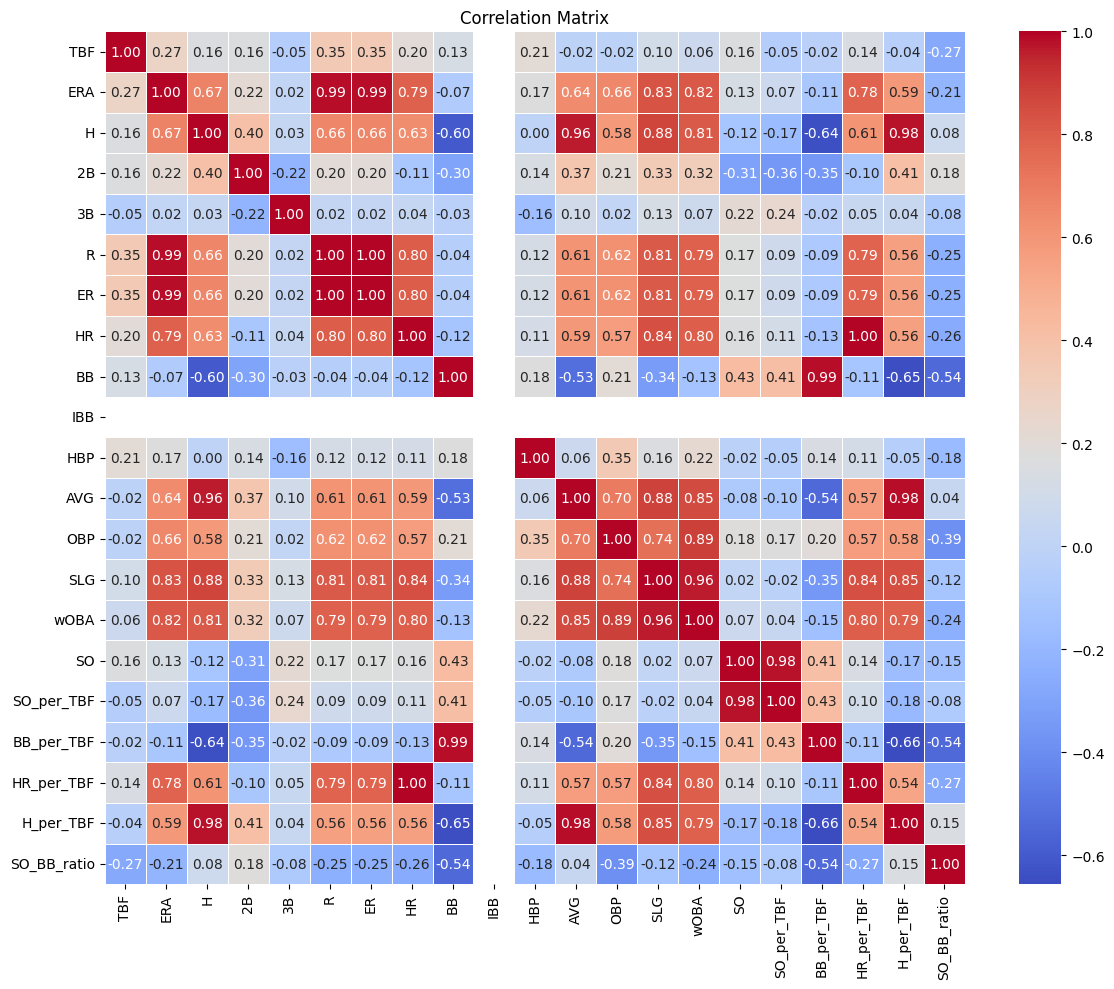


Training set: (16, 20), Test set: (5, 20)

Model Performance:
Training RMSE: 0.0052
Test RMSE: 1.4959
Training R²: 1.0000
Test R²: 0.6959
Test MAE: 1.0910


<Figure size 1200x600 with 0 Axes>

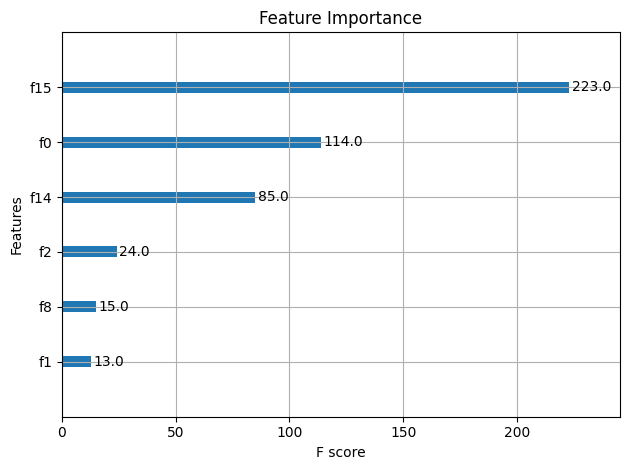


Sample Prediction for Next Game:
Predicted Strikeouts: 1.9
Actual Strikeouts: 2.0
Difference: 0.1

Model and scaler saved successfully.

Predictions for Upcoming Games:
   Actual_SO  Predicted_SO
0          2      1.920276
1          8      2.435250
2          6      2.435250
3          1      1.019549
4          2      2.435250

Model ready for deployment!


In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ========== Step 1: Load Data ==========
csv_path = '/content/Splits Leaderboard Data as SP vs ARZ.csv'  # Replace with your actual file path
if not os.path.isfile(csv_path):
    raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

try:
    df = pd.read_csv(csv_path)
    print(f"Data loaded successfully. Shape: {df.shape}")
except Exception as e:
    raise Exception(f"Error reading CSV file: {e}")

# ========== Step 2: Verify Required Columns ==========
# Updated features list as requested
features = ['TBF', 'ERA', 'H', '2B', '3B', 'R', 'ER', 'HR', 'BB', 'IBB', 'HBP', 'AVG', 'OBP', 'SLG', 'wOBA']
target = 'SO'  # New target variable

# Check if all required columns are present
required_columns = features + [target]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the data: {missing_columns}")

# ========== Step 3: Data Preprocessing ==========
# Convert percentage strings to floats if needed
percentage_cols = ['AVG', 'OBP', 'SLG', 'wOBA']  # These might be stored as strings with %
for col in percentage_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].str.rstrip('%').astype('float') / 100.0

# Handle missing values
print("\nMissing values per column:")
print(df[required_columns].isnull().sum())

# Fill missing values using appropriate strategy
for col in required_columns:
    if df[col].isnull().sum() > 0:
        # For this example, filling with median but could be customized
        df[col] = df[col].fillna(df[col].median())

# Clean the data: remove rows with extreme or invalid values
df = df[df['TBF'] > 0]  # Ensure pitcher has faced at least some batters

# Create a copy of the dataframe with only the features we need
model_df = df[required_columns].copy()
print(f"\nPreprocessed data shape: {model_df.shape}")

# ========== Step 4: Feature Engineering ==========
# Create any additional features that might help prediction
# Example: Calculate efficiency metrics
model_df['SO_per_TBF'] = model_df['SO'] / model_df['TBF']
model_df['BB_per_TBF'] = model_df['BB'] / model_df['TBF']
model_df['HR_per_TBF'] = model_df['HR'] / model_df['TBF']
model_df['H_per_TBF'] = model_df['H'] / model_df['TBF']
model_df['SO_BB_ratio'] = model_df['SO'] / (model_df['BB'] + 0.01)  # Adding 0.01 to avoid division by zero

# ========== Step 5: Exploratory Data Analysis ==========
# Check correlation with target
corr = model_df.corr()[target].sort_values(ascending=False)
print("\nFeature correlations with SO:")
print(corr)

# Plot correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = model_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

# ========== Step 6: Split Data ==========
# Split into features and target
X = model_df.drop(target, axis=1)
y = model_df[target]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# Optional: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ========== Step 7: Train XGBoost Model ==========
# Initialize XGBoost model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

# Train the model
xgb_model.fit(
    X_train_scaled,
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    verbose=False
)

# ========== Step 8: Hyperparameter Tuning ==========
# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Use smaller grid for demonstration purposes
small_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1]
}

# Run grid search (commented out to save computation time)
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=small_param_grid,
    cv=3,
    scoring='neg_mean_squared_error',
    verbose=1
)
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("\nBest parameters found: ", grid_search.best_params_)
best_model = grid_search.best_estimator_
'''

# ========== Step 9: Model Evaluation ==========
# Make predictions
y_pred_train = xgb_model.predict(X_train_scaled)
y_pred_test = xgb_model.predict(X_test_scaled)

# Calculate metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)
test_mae = mean_absolute_error(y_test, y_pred_test)

print("\nModel Performance:")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# ========== Step 10: Feature Importance ==========
# Plot feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(xgb_model, max_num_features=15)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# ========== Step 11: Predictions for Next Game ==========
# Function to predict SO for a specific pitcher
def predict_next_game_strikeouts(pitcher_data, model, scaler):
    """
    Predict next game strikeouts for a pitcher based on their stats

    Args:
        pitcher_data: DataFrame row or dict containing pitcher's stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        Predicted strikeouts for the next game
    """
    # Convert input to DataFrame if it's a dict
    if isinstance(pitcher_data, dict):
        pitcher_df = pd.DataFrame([pitcher_data])
    else:
        pitcher_df = pd.DataFrame([pitcher_data])

    # Apply same feature engineering as training data
    pitcher_df['SO_per_TBF'] = pitcher_df.get('SO', 0) / pitcher_df['TBF']  # Using get() to handle missing SO
    pitcher_df['BB_per_TBF'] = pitcher_df['BB'] / pitcher_df['TBF']
    pitcher_df['HR_per_TBF'] = pitcher_df['HR'] / pitcher_df['TBF']
    pitcher_df['H_per_TBF'] = pitcher_df['H'] / pitcher_df['TBF']
    pitcher_df['SO_BB_ratio'] = pitcher_df.get('SO', 0) / (pitcher_df['BB'] + 0.01)

    # Remove SO from features if present (it's our target)
    if 'SO' in pitcher_df.columns:
        pitcher_df.drop('SO', axis=1, inplace=True)

    # Ensure we have all required columns in the right order
    missing_cols = set(X_train.columns) - set(pitcher_df.columns)
    for col in missing_cols:
        pitcher_df[col] = 0  # Set default values for missing columns

    pitcher_df = pitcher_df[X_train.columns]  # Reorder columns to match training data

    # Scale features
    scaled_features = scaler.transform(pitcher_df)

    # Make prediction
    prediction = model.predict(scaled_features)[0]

    return prediction

# Example: Predicting for a sample pitcher
# (This would be replaced with actual pitcher data)
sample_pitcher = X_test.iloc[0].to_dict()  # Using first test set example
predicted_strikeouts = predict_next_game_strikeouts(sample_pitcher, xgb_model, scaler)
actual_strikeouts = y_test.iloc[0]

print("\nSample Prediction for Next Game:")
print(f"Predicted Strikeouts: {predicted_strikeouts:.1f}")
print(f"Actual Strikeouts: {actual_strikeouts:.1f}")
print(f"Difference: {abs(predicted_strikeouts - actual_strikeouts):.1f}")

# ========== Step 12: Save Model ==========
# Save model and scaler for future use
xgb_model.save_model('mlb_pitcher_strikeouts_model.json')
import joblib
joblib.dump(scaler, 'strikeouts_scaler.pkl')

print("\nModel and scaler saved successfully.")

# ========== Step 13: Batch Predictions for Upcoming Games ==========
# Function to make predictions for multiple pitchers
def predict_upcoming_games(pitchers_df, model, scaler):
    """
    Make strikeout predictions for multiple upcoming pitchers

    Args:
        pitchers_df: DataFrame with upcoming pitchers stats
        model: Trained XGBoost model
        scaler: Fitted StandardScaler

    Returns:
        DataFrame with original stats and predictions
    """
    # Create a copy to avoid modifying original
    result_df = pitchers_df.copy()

    # Apply same feature engineering
    if 'SO' in result_df.columns:
        result_df['SO_per_TBF'] = result_df['SO'] / result_df['TBF']
    else:
        result_df['SO_per_TBF'] = 0  # Default if SO not provided

    result_df['BB_per_TBF'] = result_df['BB'] / result_df['TBF']
    result_df['HR_per_TBF'] = result_df['HR'] / result_df['TBF']
    result_df['H_per_TBF'] = result_df['H'] / result_df['TBF']

    if 'SO' in result_df.columns:
        result_df['SO_BB_ratio'] = result_df['SO'] / (result_df['BB'] + 0.01)
    else:
        result_df['SO_BB_ratio'] = 0  # Default if SO not provided

    # Remove SO if present (it's our target)
    if 'SO' in result_df.columns:
        result_df.drop('SO', axis=1, inplace=True)

    # Ensure we have all the required columns in the right order
    for col in X_train.columns:
        if col not in result_df.columns:
            result_df[col] = 0  # Add missing columns with default values

    # Extract features in the same order as training
    features_df = result_df[X_train.columns]

    # Scale features
    scaled_features = scaler.transform(features_df)

    # Make predictions
    predictions = model.predict(scaled_features)

    # Add predictions to result
    result_df['Predicted_SO'] = predictions

    return result_df

# Example: Predict for a sample of upcoming pitchers
# (This would be replaced with actual upcoming pitcher data)
sample_upcoming_pitchers = X_test.head(5).copy()  # Using first 5 test examples
predictions_df = predict_upcoming_games(sample_upcoming_pitchers, xgb_model, scaler)

print("\nPredictions for Upcoming Games:")
comparison_df = pd.DataFrame({
    'Actual_SO': y_test.head(5).values,
    'Predicted_SO': predictions_df['Predicted_SO'].values
})
print(comparison_df)

print("\nModel ready for deployment!")

Dataset overview:
             PA      AVG      OBP      SLG      OPS      ISO    BABIP  \
count   300.000  300.000  300.000  300.000  300.000  300.000  300.000   
mean   6298.550    0.249    0.321    0.416    0.736    0.167    0.301   
std     280.632    0.026    0.030    0.043    0.055    0.046    0.021   
min    5801.000    0.200    0.270    0.300    0.600    0.080    0.248   
25%    6051.750    0.232    0.299    0.387    0.699    0.134    0.287   
50%    6302.000    0.250    0.319    0.413    0.736    0.165    0.302   
75%    6530.000    0.269    0.342    0.444    0.772    0.201    0.316   
max    6796.000    0.330    0.400    0.537    0.900    0.250    0.362   

           BB%       K%     BB/K     wOBA     wRC+      wRC     wRAA  
count  300.000  300.000  300.000  300.000  300.000  300.000  300.000  
mean     0.090    0.223    0.409    0.359  112.329  777.933  197.797  
std      0.014    0.025    0.083    0.025   10.413   76.346  134.877  
min      0.040    0.154    0.191    0.28

<Figure size 1200x600 with 0 Axes>

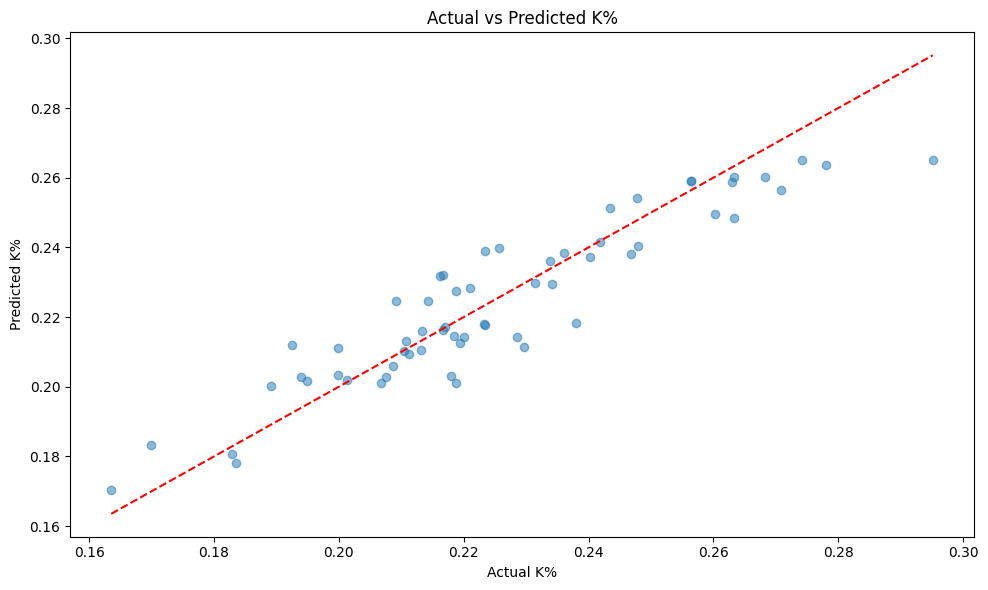

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Sample function to load your data
# Replace this with your actual data loading code
def load_data():
    """
    Load batting data from CSV file or other source
    Returns a pandas DataFrame with the required columns
    """
    # For demonstration - replace with your actual data loading
    # df = pd.read_csv('team_batting_stats.csv')

    # Creating a sample dataset for demonstration
    # In real use, replace this with your actual dataset
    n_samples = 300  # Example: 30 teams over 10 seasons

    # Generate synthetic data with realistic correlations between baseball metrics
    df = pd.DataFrame()

    # Plate appearances (PA) - typical range for team season ~6000-6500
    df['PA'] = np.random.randint(5800, 6800, n_samples)

    # Base metrics with realistic ranges
    df['AVG'] = np.random.normal(0.250, 0.025, n_samples)  # Batting average
    df['OBP'] = df['AVG'] + np.random.normal(0.070, 0.015, n_samples)  # On-base percentage
    df['SLG'] = np.random.normal(0.410, 0.040, n_samples)  # Slugging
    df['OPS'] = df['OBP'] + df['SLG']  # On-base plus slugging
    df['ISO'] = df['SLG'] - df['AVG']  # Isolated power
    df['BABIP'] = np.random.normal(0.300, 0.020, n_samples)  # Batting avg on balls in play

    # Walk-related metrics
    df['BB%'] = np.random.normal(0.090, 0.015, n_samples)  # Walk percentage

    # Target variable - K% (strikeout percentage)
    # Teams with higher power (ISO, SLG) tend to have higher K%
    df['K%'] = 0.12 + 0.5 * df['ISO'] + np.random.normal(0.02, 0.01, n_samples)
    df['K%'] = np.clip(df['K%'], 0.10, 0.30)  # Realistic range

    # BB/K ratio - derived from BB% and K%
    df['BB/K'] = df['BB%'] / df['K%']

    # Advanced metrics
    df['wOBA'] = 0.7 * df['OBP'] + 0.3 * df['SLG'] + np.random.normal(0.01, 0.005, n_samples)
    df['wRC+'] = 100 * (df['wOBA'] / 0.320) + np.random.normal(0, 5, n_samples)

    # wRC and wRAA are counting stats dependent on PA
    df['wRC'] = df['PA'] * (df['wRC+'] / 100) * 0.11
    df['wRAA'] = (df['wOBA'] - 0.320) * df['PA'] / 1.25

    # Clean up any unrealistic values
    df['AVG'] = np.clip(df['AVG'], 0.200, 0.330)
    df['OBP'] = np.clip(df['OBP'], 0.270, 0.400)
    df['SLG'] = np.clip(df['SLG'], 0.300, 0.550)
    df['OPS'] = np.clip(df['OPS'], 0.600, 0.900)
    df['ISO'] = np.clip(df['ISO'], 0.080, 0.250)
    df['wOBA'] = np.clip(df['wOBA'], 0.280, 0.400)
    df['wRC+'] = np.clip(df['wRC+'], 70, 140)

    return df

# Load the data
data = load_data()

# Display summary statistics
print("Dataset overview:")
print(data.describe().round(3))

# Define features and target
features = ['PA', 'BB%', 'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'wRC', 'wRAA', 'wOBA', 'wRC+']
target = 'K%'

X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an initial XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance Metrics:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

# Feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, height=0.8, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.tight_layout()
plt.savefig('feature_importance.png')

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Comment out for quick execution - uncomment for thorough hyperparameter tuning
'''
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_:.6f} (MSE)")

# Train the model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions with the tuned model
y_pred_tuned = best_model.predict(X_test)

# Evaluate the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"Tuned Model Performance Metrics:")
print(f"MSE: {mse_tuned:.6f}")
print(f"RMSE: {rmse_tuned:.6f}")
print(f"R² Score: {r2_tuned:.6f}")
'''

# Function to predict K% for new data
def predict_strikeout_percentage(model, new_data):
    """
    Predict K% using the trained model

    Parameters:
    model (XGBRegressor): Trained XGBoost model
    new_data (DataFrame): New team data with required features

    Returns:
    float: Predicted K% value
    """
    # Ensure all required features are present
    required_features = ['PA', 'BB%', 'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'wRC', 'wRAA', 'wOBA', 'wRC+']
    missing_features = [feat for feat in required_features if feat not in new_data.columns]

    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

    # Make prediction
    prediction = model.predict(new_data[required_features])
    return prediction[0]

# Example usage with sample data
sample_team = pd.DataFrame({
    'PA': [6200],
    'BB%': [0.095],
    'BB/K': [0.45],
    'AVG': [0.265],
    'OBP': [0.338],
    'SLG': [0.425],
    'OPS': [0.763],
    'ISO': [0.160],
    'BABIP': [0.305],
    'wRC': [720],
    'wRAA': [15.5],
    'wOBA': [0.335],
    'wRC+': [110]
})

predicted_k_pct = predict_strikeout_percentage(model, sample_team)
print(f"Predicted K% for sample team: {predicted_k_pct:.4f} ({predicted_k_pct*100:.2f}%)")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual K%')
plt.ylabel('Predicted K%')
plt.title('Actual vs Predicted K%')
plt.tight_layout()
plt.savefig('prediction_performance.png')

# Partial dependence plots for key features
# Uncomment to create partial dependence plots
'''
from sklearn.inspection import partial_dependence, plot_partial_dependence

features_to_plot = [0, 2, 7]  # Indices for PA, BB/K, ISO
plot_partial_dependence(model, X_train, features_to_plot,
                       feature_names=features, n_jobs=-1)
plt.suptitle('Partial Dependence Plots for Key Features')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig('partial_dependence.png')
'''

# Save the model for future use
model.save_model('team_k_percentage_predictor.json')

print("Model saved as 'team_k_percentage_predictor.json'")
print("\nTo use this model in production:")
print("1. Load real team batting data with all required features")
print("2. Preprocess the data to match the training data format")
print("3. Load the model and make predictions")
print("4. Analyze results and update the model periodically")

Data loaded successfully. Shape: (20, 16)

Dataset overview:
           PA     BB%      K%    BB/K     AVG     OBP     SLG     OPS     ISO  \
count  20.000  20.000  20.000  20.000  20.000  20.000  20.000  20.000  20.000   
mean   37.750   0.103   0.200   0.559   0.233   0.328   0.403   0.730   0.170   
std     3.007   0.056   0.073   0.363   0.075   0.062   0.205   0.246   0.145   
min    33.000   0.000   0.093   0.000   0.067   0.200   0.067   0.267   0.000   
25%    35.750   0.058   0.160   0.302   0.209   0.291   0.281   0.594   0.082   
50%    37.000   0.104   0.183   0.551   0.232   0.337   0.333   0.672   0.118   
75%    39.500   0.145   0.245   0.750   0.294   0.385   0.523   0.886   0.263   
max    43.000   0.206   0.371   1.600   0.333   0.415   0.800   1.156   0.475   

        BABIP     wRC    wRAA    wOBA     wRC+  
count  20.000  20.000  20.000  20.000   20.000  
mean    0.263   4.950   0.602   0.326  117.239  
std     0.072   3.026   2.770   0.091   63.974  
min     0.118

<Figure size 1200x600 with 0 Axes>

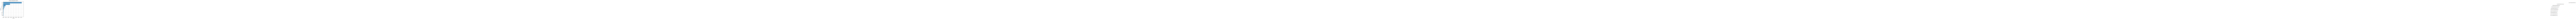

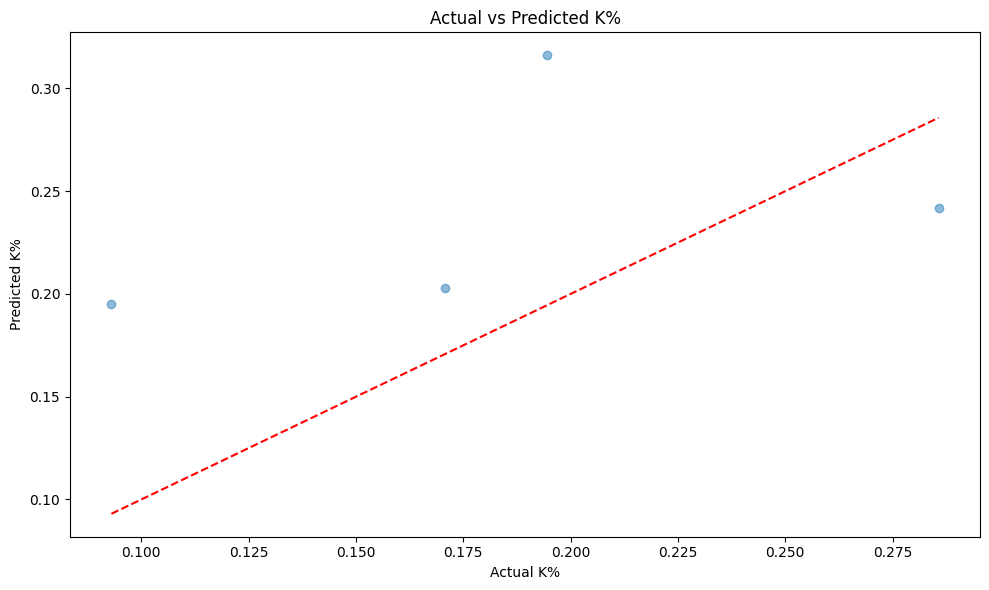

In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed for reproducibility
np.random.seed(42)

# Function to load data from CSV file
def load_data(csv_path):
    """
    Load batting data from CSV file

    Parameters:
    csv_path (str): Path to the CSV file

    Returns:
    pandas.DataFrame: Dataframe containing the batting statistics
    """
    # Check if file exists
    if not os.path.isfile(csv_path):
        raise FileNotFoundError(f"The file does not exist at the provided path: {csv_path}")

    try:
        # Load the data
        df = pd.read_csv(csv_path)
        print(f"Data loaded successfully. Shape: {df.shape}")

        # Verify that required columns are present
        required_features = ['PA', 'BB%', 'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'wRC', 'wRAA', 'wOBA', 'wRC+', 'K%']
        missing_columns = [col for col in required_features if col not in df.columns]

        if missing_columns:
            print(f"Warning: The following required columns are missing: {missing_columns}")
            print("Available columns:", df.columns.tolist())

        # Clean the data - handle percentage columns if needed
        # Some CSV exports might have percentages as strings with % sign
        for col in df.columns:
            if '%' in col:
                if df[col].dtype == 'object':
                    # Remove % sign and convert to float if present
                    df[col] = df[col].str.rstrip('%').astype('float') / 100
                    print(f"Converted {col} from percentage string to float")

        return df

    except Exception as e:
        raise Exception(f"Error reading CSV file: {e}")

# CSV file path - update this to your file path
csv_path = '/content/Splits Leaderboard Data vs CHW.csv'  # Example path

# Load the data
data = load_data(csv_path)

# Display summary statistics
print("\nDataset overview:")
print(data.describe().round(3))

# Check for missing values
print("\nMissing values in each column:")
print(data.isnull().sum())

# Handle missing values if any
if data.isnull().sum().sum() > 0:
    print("Handling missing values...")
    # For numeric columns, fill with median
    for col in data.select_dtypes(include=['float64', 'int64']).columns:
        if data[col].isnull().sum() > 0:
            median_val = data[col].median()
            data[col].fillna(median_val, inplace=True)
            print(f"Filled missing values in {col} with median: {median_val}")

# Define features and target
features = ['PA', 'BB%', 'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'wRC', 'wRAA', 'wOBA', 'wRC+']
target = 'K%'

# Verify that all needed columns exist after cleaning
for col in features + [target]:
    if col not in data.columns:
        raise ValueError(f"Required column '{col}' not found in the dataset")

X = data[features]
y = data[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Data preprocessing check
print(f"\nTraining data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

# Train an initial XGBoost model
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42
)

model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance Metrics:")
print(f"MSE: {mse:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R² Score: {r2:.6f}")

# Feature importance
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, height=0.8, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.tight_layout()
plt.savefig('feature_importance.png')
print("Feature importance plot saved as 'feature_importance.png'")

# Hyperparameter tuning with GridSearchCV
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Comment out for quick execution - uncomment for thorough hyperparameter tuning
'''
print("\nStarting hyperparameter tuning. This may take some time...")
grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {-grid_search.best_score_:.6f} (MSE)")

# Train the model with best parameters
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

# Make predictions with the tuned model
y_pred_tuned = best_model.predict(X_test)

# Evaluate the tuned model
mse_tuned = mean_squared_error(y_test, y_pred_tuned)
rmse_tuned = np.sqrt(mse_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

print(f"\nTuned Model Performance Metrics:")
print(f"MSE: {mse_tuned:.6f}")
print(f"RMSE: {rmse_tuned:.6f}")
print(f"R² Score: {r2_tuned:.6f}")

# Save the tuned model
best_model.save_model('team_k_percentage_predictor_tuned.json')
print("Tuned model saved as 'team_k_percentage_predictor_tuned.json'")
'''

# Function to predict K% for new data
def predict_strikeout_percentage(model, new_data):
    """
    Predict K% using the trained model

    Parameters:
    model (XGBRegressor): Trained XGBoost model
    new_data (DataFrame): New team data with required features

    Returns:
    float: Predicted K% value
    """
    # Ensure all required features are present
    required_features = ['PA', 'BB%', 'BB/K', 'AVG', 'OBP', 'SLG', 'OPS', 'ISO', 'BABIP', 'wRC', 'wRAA', 'wOBA', 'wRC+']
    missing_features = [feat for feat in required_features if feat not in new_data.columns]

    if missing_features:
        raise ValueError(f"Missing required features: {missing_features}")

    # Make prediction
    prediction = model.predict(new_data[required_features])
    return prediction

# Example: How to use the model for prediction
print("\nExample: Predicting K% for the first 5 entries in the test set:")
sample_predictions = predict_strikeout_percentage(model, X_test.iloc[:5])
for i, pred in enumerate(sample_predictions[:5]):
    print(f"Sample {i+1}: Predicted K%: {pred:.4f} ({pred*100:.2f}%), Actual K%: {y_test.iloc[i]:.4f} ({y_test.iloc[i]*100:.2f}%)")

# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.xlabel('Actual K%')
plt.ylabel('Predicted K%')
plt.title('Actual vs Predicted K%')
plt.tight_layout()
plt.savefig('prediction_performance.png')
print("Prediction performance plot saved as 'prediction_performance.png'")

# Save the model for future use
model.save_model('team_k_percentage_predictor.json')
print("\nModel saved as 'team_k_percentage_predictor.json'")

print("\nTo use this model in production:")
print("1. Load real team batting data with all required features")
print("2. If needed, preprocess percentage columns to be decimal values")
print("3. Load the model using: model = xgb.XGBRegressor(); model.load_model('team_k_percentage_predictor.json')")
print("4. Make predictions with new data using the predict_strikeout_percentage function")